# Codice progetto BISF 887447 Ferraro Carmelo 2023-2024, Luglio 2024

## 1. Sommario dei dati utilizzati

In [6]:
# Librerie usate

import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
import warnings
warnings.filterwarnings("ignore")

import pprint 

import math

import statsmodels.formula.api as smf

import scipy.optimize as sco

sns.set()  # This sets the Seaborn style for matplotlib


In [7]:
# Periodo analizzato
start = datetime(2014,5,31)
end = datetime(2024,5,31)

In [8]:
stocks = dict([]) # Dizionario che contiene i dati dei titoli scaricati

In [9]:
# JPMorgan Chase & Co, The Goldman Sachs Group, Pfizer, AbbVie, NVIDIA, Apple.
stocks_names = ['JPM', 'GS', 'PFE', 'ABBV', 'NVDA', 'AAPL'] # lista coi ticker
for name in stocks_names: # per ogni ticker scarico i dati e li metto nel dict
    stocks.update({name:yf.download(name, start=start, end=end)})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
stocks['JPM'].head()

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-06-02  55.650002  55.650002  55.020000  55.349998  41.671864   9440000
2014-06-03  55.090000  55.660000  55.090000  55.599998  41.860088   9131500
2014-06-04  55.520000  55.730000  55.250000  55.680000  41.920326   9727800
2014-06-05  55.910000  56.660000  55.490002  56.630001  42.635571  16803400
2014-06-06  56.759998  57.130001  56.650002  56.970001  42.891544  15399800

<Axes: xlabel='Date'>

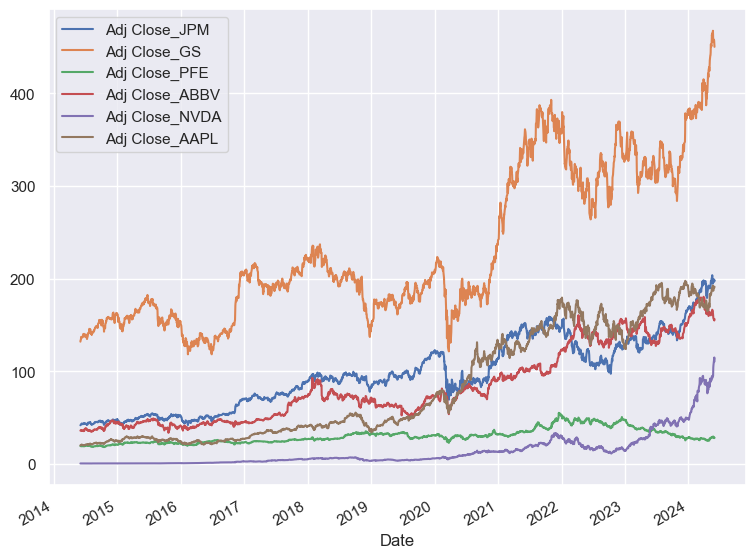

In [11]:
adj_closes = pd.DataFrame() # Dataframe che contiene gli adj close dei titoli
for name in stocks_names:
    tmp_df = stocks[name]['Adj Close'].to_frame()
    tmp_df.columns = ['Adj Close_' + name]
    adj_closes = pd.concat([adj_closes, tmp_df], axis=1)
    
    
adj_closes.plot(grid=True, figsize=(9,7), legend=True)

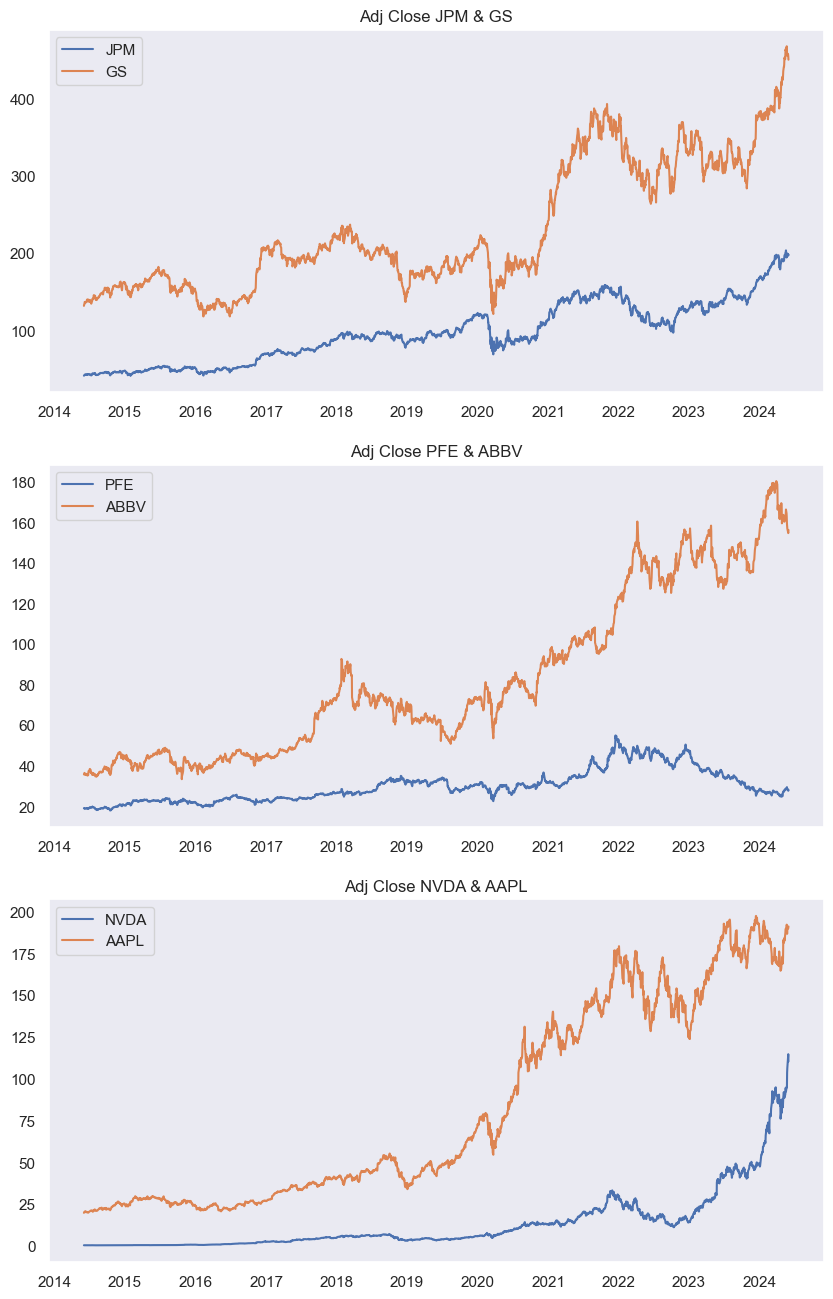

In [12]:
plt.figure(figsize=(10,16))
for index in range(0, len(stocks_names)-1, 2):
    name_1 = stocks_names[index]
    name_2 = stocks_names[index+1]
    
    plt.subplot(311 + int(index/2))
    plt.title('Adj Close ' + name_1 + ' & ' + name_2)
    plt.plot(stocks[name_1]['Adj Close'])
    plt.plot(stocks[name_2]['Adj Close'])
    plt.legend([name_1, name_2], loc='upper left')
    plt.grid()

In [13]:
adj_closes.head()

Adj Close_JPM  Adj Close_GS  Adj Close_PFE  Adj Close_ABBV  \
Date                                                                     
2014-06-02      41.671864    131.946930      19.234701       35.876869   
2014-06-03      41.860088    133.406387      19.157011       36.022629   
2014-06-04      41.920326    133.892868      19.189375       36.161774   
2014-06-05      42.635571    134.049484      19.267069       36.638802   
2014-06-06      42.891544    137.026001      19.046947       36.506283   

            Adj Close_NVDA  Adj Close_AAPL  
Date                                        
2014-06-02        0.450742       19.859402  
2014-06-03        0.448839       20.140240  
2014-06-04        0.449315       20.370216  
2014-06-05        0.451218       20.450144  
2014-06-06        0.452884       20.393906

In [14]:
adj_closes.tail()

Adj Close_JPM  Adj Close_GS  Adj Close_PFE  Adj Close_ABBV  \
Date                                                                     
2024-05-23     195.834854    455.394104      28.690001      158.259995   
2024-05-24     199.603973    458.405884      28.879999      157.059998   
2024-05-28     198.400635    457.044128      28.299999      155.339996   
2024-05-29     197.018295    454.420013      27.820000      154.789993   
2024-05-30     198.231583    450.230011      28.200001      156.309998   

            Adj Close_NVDA  Adj Close_AAPL  
Date                                        
2024-05-23      103.790482      186.880005  
2024-05-24      106.460258      189.979996  
2024-05-28      113.891647      189.990005  
2024-05-29      114.815567      190.289993  
2024-05-30      110.490921      191.289993

In [15]:
adj_closes.describe()

Adj Close_JPM  Adj Close_GS  Adj Close_PFE  Adj Close_ABBV  \
count    2517.000000   2517.000000    2517.000000     2517.000000   
mean       96.796964    230.514910      30.039570       82.875203   
std        38.477160     81.741431       7.834620       39.991138   
min        41.671864    118.272346      18.091618       33.530449   
25%        64.047592    166.560974      23.838579       46.486343   
50%        92.553658    198.399307      28.515430       71.587151   
75%       126.975853    310.266235      33.677441      107.903084   
max       203.661484    467.580383      55.076664      180.415100   

       Adj Close_NVDA  Adj Close_AAPL  
count     2517.000000     2517.000000  
mean        13.319601       82.479946  
std         18.325410       58.867008  
min          0.401343       19.859402  
25%          2.271587       28.774818  
50%          5.837435       50.554955  
75%         16.942295      142.783707  
max        114.815567      197.589523

## 2. Statistiche descrittive

In [16]:
# Rendimento cumulato

cum_rtn = pd.DataFrame()

for index in range(0, len(stocks_names)):
    cum_rtn['cum_rtn_' + stocks_names[index]] = [adj_closes.iloc[-1, index] / adj_closes.iloc[0, index] - 1]
    
cum_rtn

cum_rtn_JPM  cum_rtn_GS  cum_rtn_PFE  cum_rtn_ABBV  cum_rtn_NVDA  \
0     3.756965    2.412205       0.4661      3.356846    244.130939   

   cum_rtn_AAPL  
0      8.632213

In [17]:
# Rendimento composto annuo

comp_rtn = pd.DataFrame()

for index in range(0, len(stocks_names)):
    # (radice decima di (valore finale/valore iniziale)) - 1
    comp_rtn['y_comp_rtn_' + stocks_names[index]] = [((adj_closes.iloc[-1, index] / adj_closes.iloc[0, index]) ** (1/10)) - 1]
    
comp_rtn

y_comp_rtn_JPM  y_comp_rtn_GS  y_comp_rtn_PFE  y_comp_rtn_ABBV  \
0        0.168781       0.130586        0.039002         0.158557   

   y_comp_rtn_NVDA  y_comp_rtn_AAPL  
0         0.733564         0.254217

In [18]:
# Rednimento semplice

simple_ret = adj_closes / adj_closes.shift(1) - 1 

simple_ret.dropna(inplace=True)

simple_ret.columns = ['[D] Simple ret. ' + name for name in stocks_names]

simple_ret.head()

[D] Simple ret. JPM  [D] Simple ret. GS  [D] Simple ret. PFE  \
Date                                                                       
2014-06-03             0.004517            0.011061            -0.004039   
2014-06-04             0.001439            0.003647             0.001689   
2014-06-05             0.017062            0.001170             0.004049   
2014-06-06             0.006004            0.022205            -0.011425   
2014-06-09             0.007899           -0.001144            -0.002379   

            [D] Simple ret. ABBV  [D] Simple ret. NVDA  [D] Simple ret. AAPL  
Date                                                                          
2014-06-03              0.004063             -0.004224              0.014141  
2014-06-04              0.003863              0.001060              0.011419  
2014-06-05              0.013191              0.004238              0.003924  
2014-06-06             -0.003617              0.003692             -0.002750  
2014-06-09             -0.022867              0.001051              0.016002

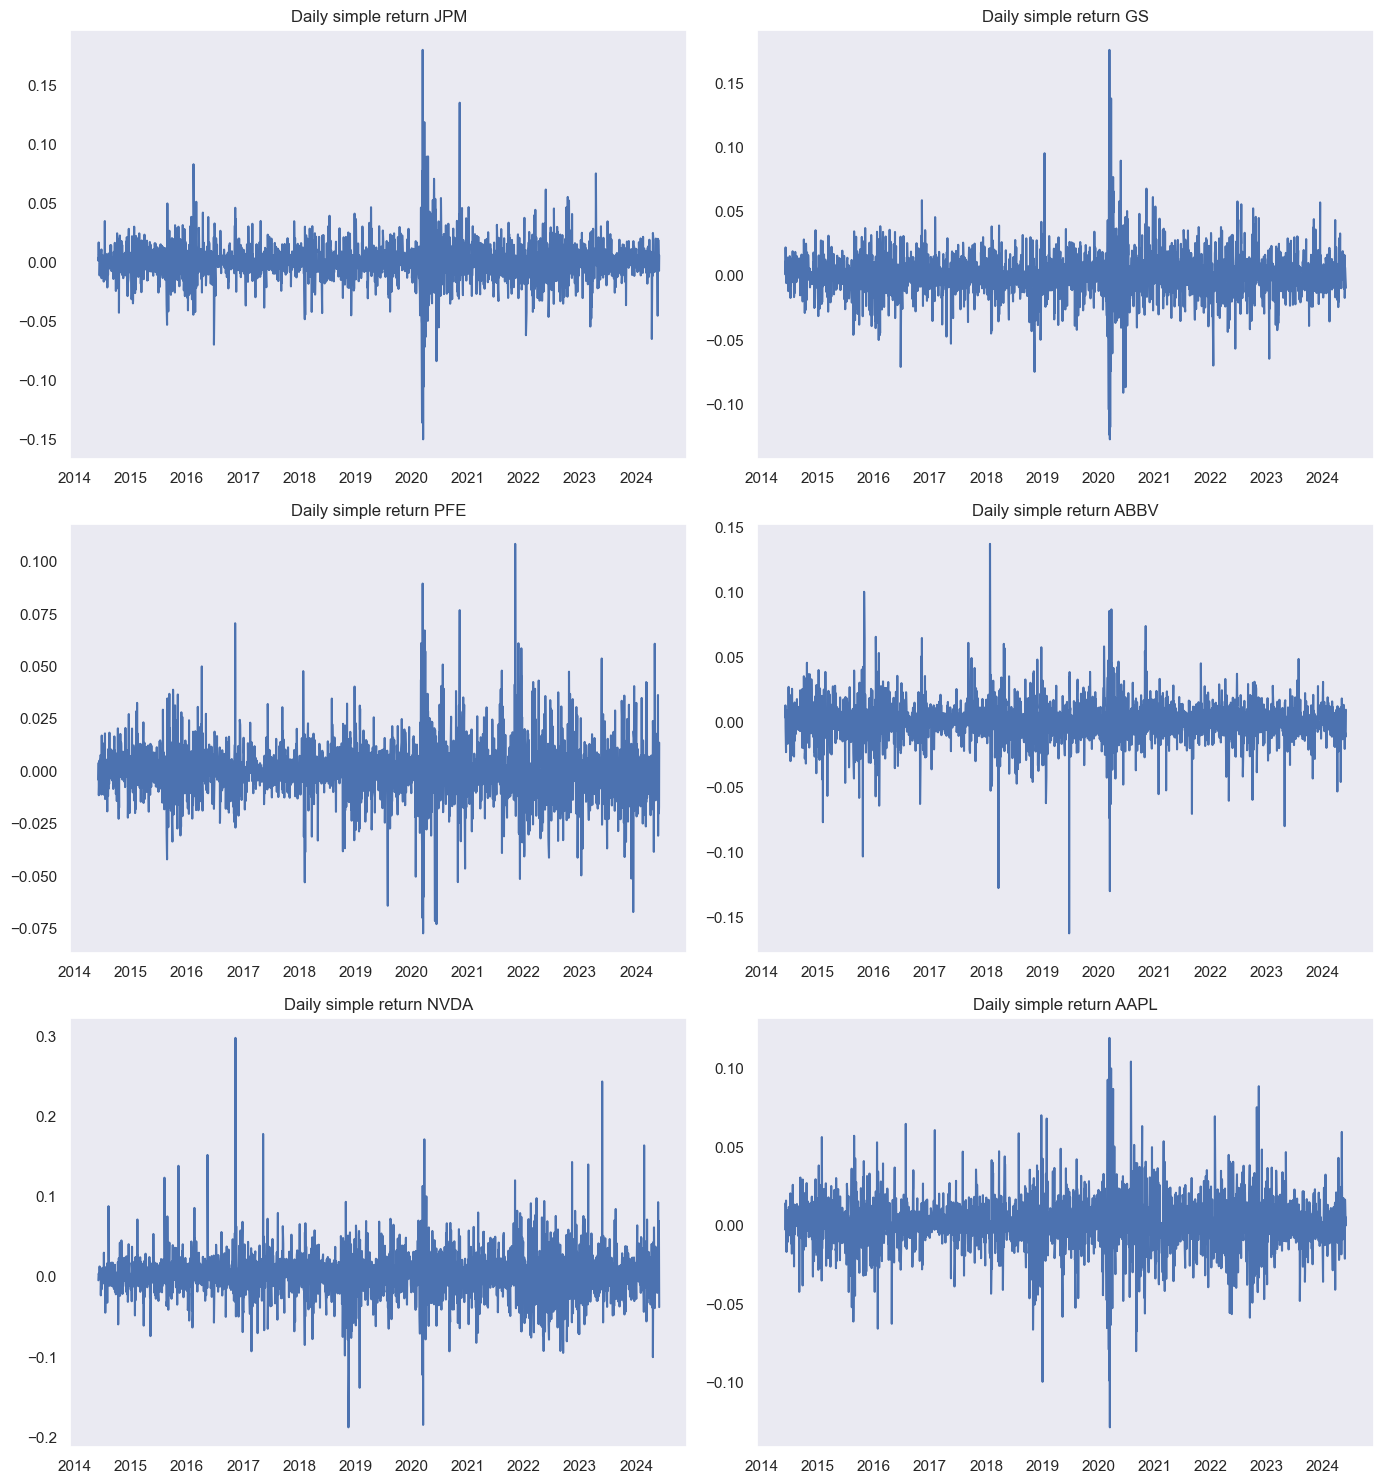

In [19]:
plt.figure(figsize=(14, 15))
for index in range(len(stocks_names)):
    name = stocks_names[index]
    plt.subplot(321 + index)  # 3 righe, 2 colonne, numero figura (parte da 1)
    plt.title('Daily simple return ' + name)
    plt.plot(simple_ret['[D] Simple ret. ' + name])
    plt.grid()

plt.tight_layout()
plt.show()


In [20]:
# Rendimento logaritmico

daily_log_rtn = np.log(1 + simple_ret) 

daily_log_rtn.columns = ['[D] Log ret. ' + name for name in stocks_names]

daily_log_rtn.head()

[D] Log ret. JPM  [D] Log ret. GS  [D] Log ret. PFE  \
Date                                                              
2014-06-03          0.004507         0.011000         -0.004047   
2014-06-04          0.001438         0.003640          0.001688   
2014-06-05          0.016918         0.001169          0.004041   
2014-06-06          0.005986         0.021962         -0.011491   
2014-06-09          0.007868        -0.001144         -0.002382   

            [D] Log ret. ABBV  [D] Log ret. NVDA  [D] Log ret. AAPL  
Date                                                                 
2014-06-03           0.004055          -0.004233           0.014042  
2014-06-04           0.003855           0.001060           0.011354  
2014-06-05           0.013105           0.004229           0.003916  
2014-06-06          -0.003623           0.003685          -0.002754  
2014-06-09          -0.023133           0.001050           0.015875

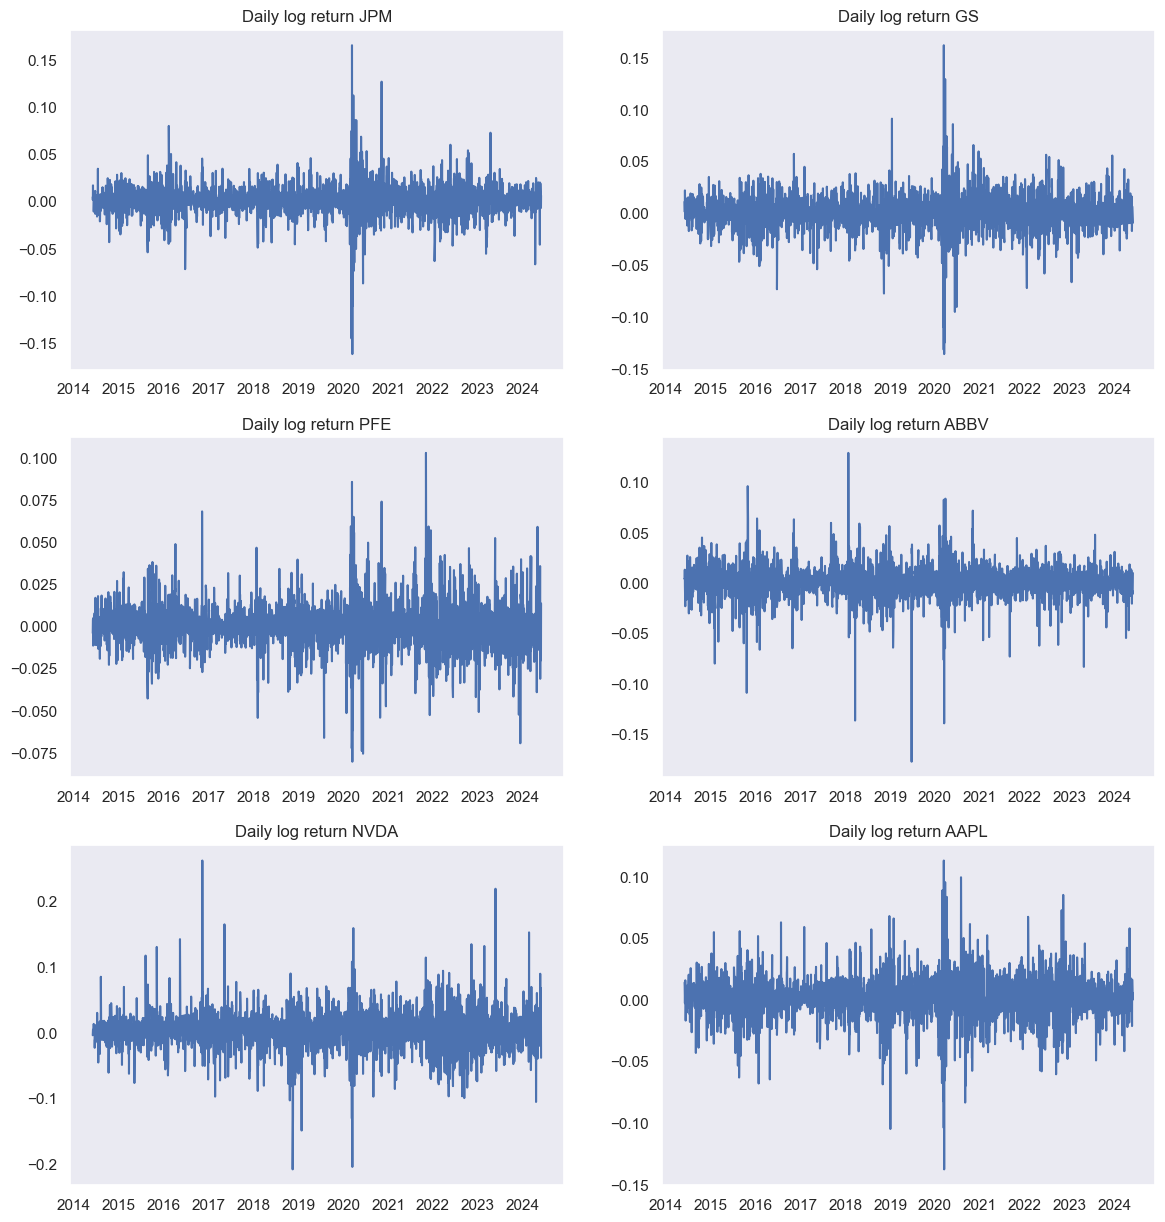

In [21]:
plt.figure(figsize=(14,15))
for index in range(0, len(stocks_names)):
    name = stocks_names[index]
    plt.subplot(321 + index) # 3 righe, 2 colonne, numero figura (parte da 1)
    plt.title('Daily log return ' + name)
    plt.plot(daily_log_rtn['[D] Log ret. ' + name])
    plt.grid()

In [22]:
daily_log_rtn.describe()

[D] Log ret. JPM  [D] Log ret. GS  [D] Log ret. PFE  [D] Log ret. ABBV  \
count       2516.000000      2516.000000       2516.000000        2516.000000   
mean           0.000620         0.000488          0.000152           0.000585   
std            0.016953         0.017780          0.014355           0.016804   
min           -0.162106        -0.135880         -0.080502          -0.177362   
25%           -0.007090        -0.008310         -0.006725          -0.006981   
50%            0.000615         0.000425          0.000000           0.001225   
75%            0.008487         0.009707          0.007011           0.008674   
max            0.165620         0.161951          0.103055           0.128985   

       [D] Log ret. NVDA  [D] Log ret. AAPL  
count        2516.000000        2516.000000  
mean            0.002187           0.000900  
std             0.029572           0.017846  
min            -0.207711          -0.137708  
25%            -0.011691          -0.007342  
50%             0.002388           0.000821  
75%             0.016813           0.010090  
max             0.260876           0.113157

In [23]:
correlazioni = daily_log_rtn.corr()
print("Matrice di correlazione:\n", correlazioni)

Matrice di correlazione:
                    [D] Log ret. JPM  [D] Log ret. GS  [D] Log ret. PFE  \
[D] Log ret. JPM           1.000000         0.825579          0.381404   
[D] Log ret. GS            0.825579         1.000000          0.341868   
[D] Log ret. PFE           0.381404         0.341868          1.000000   
[D] Log ret. ABBV          0.360551         0.331988          0.435850   
[D] Log ret. NVDA          0.352284         0.404273          0.192428   
[D] Log ret. AAPL          0.435876         0.477110          0.308339   

                   [D] Log ret. ABBV  [D] Log ret. NVDA  [D] Log ret. AAPL  
[D] Log ret. JPM            0.360551           0.352284           0.435876  
[D] Log ret. GS             0.331988           0.404273           0.477110  
[D] Log ret. PFE            0.435850           0.192428           0.308339  
[D] Log ret. ABBV           1.000000           0.232127           0.294903  
[D] Log ret. NVDA           0.232127           1.000000           0.55

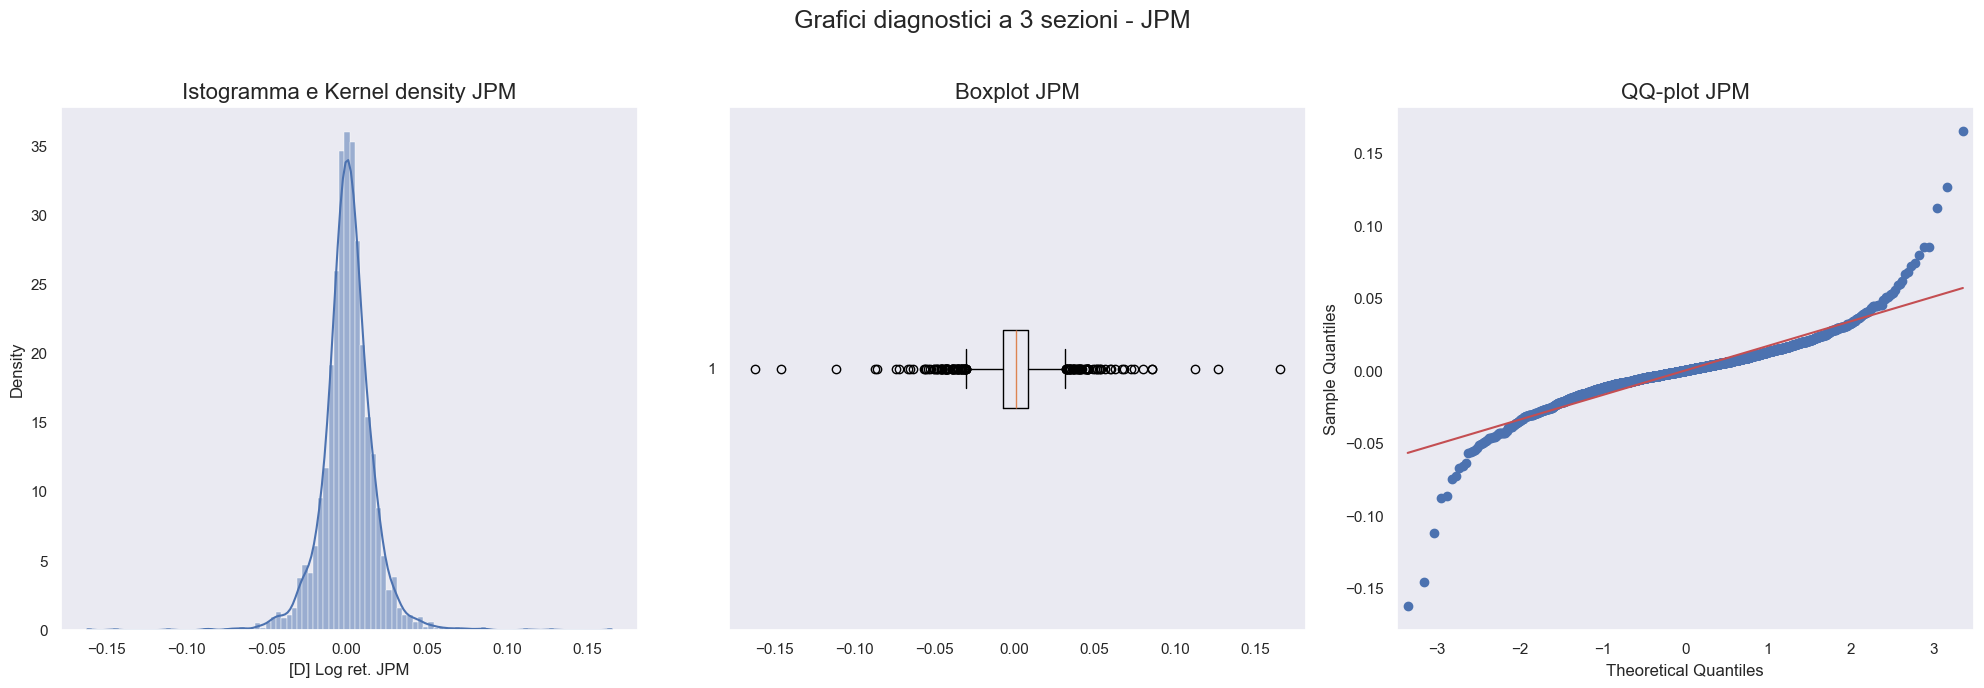

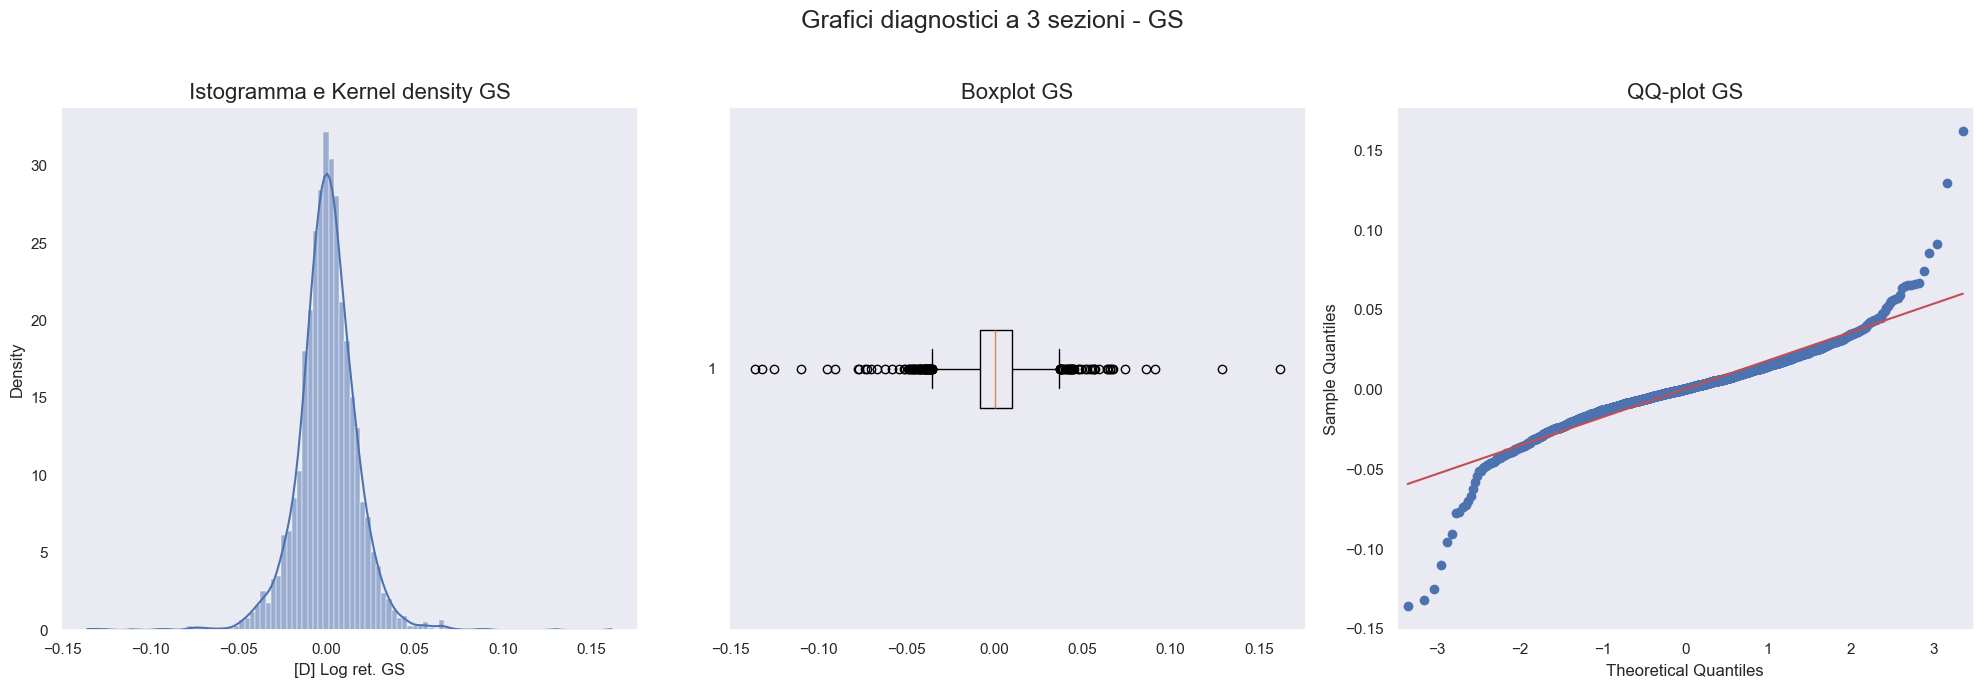

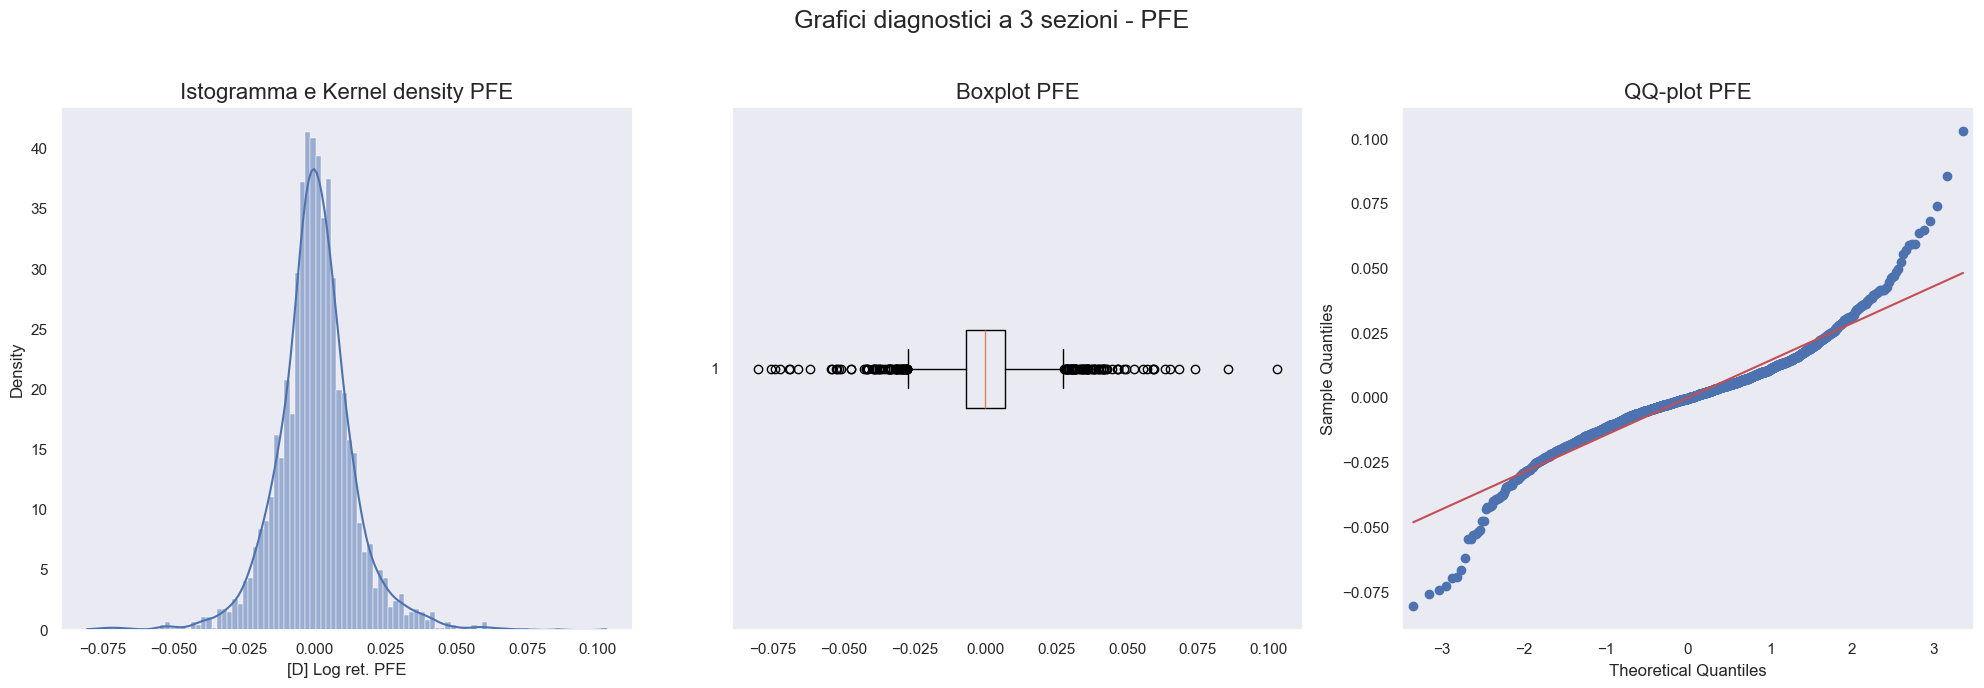

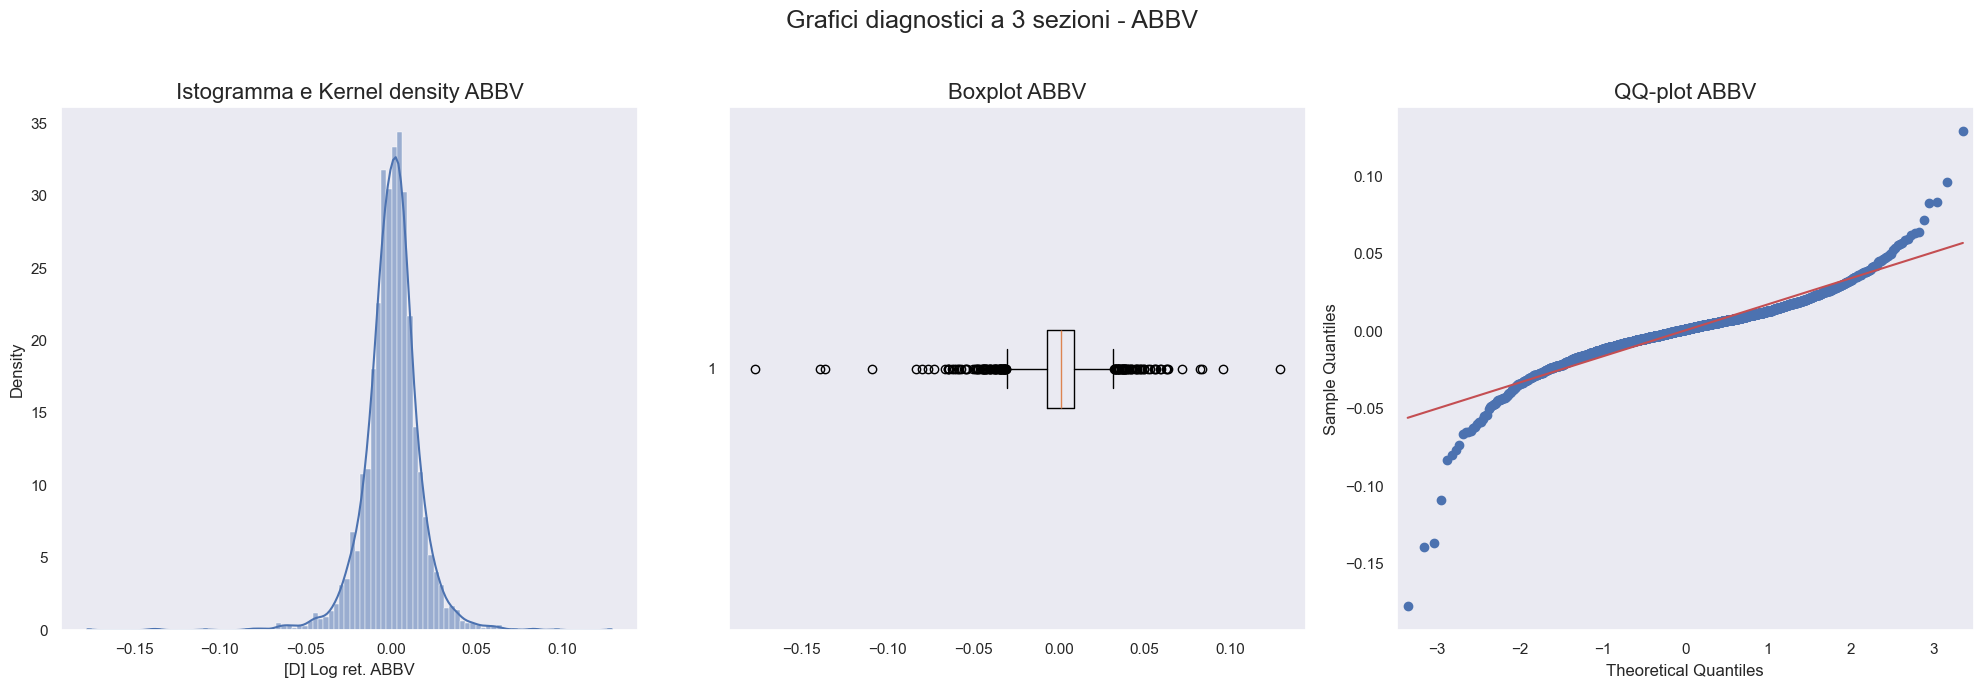

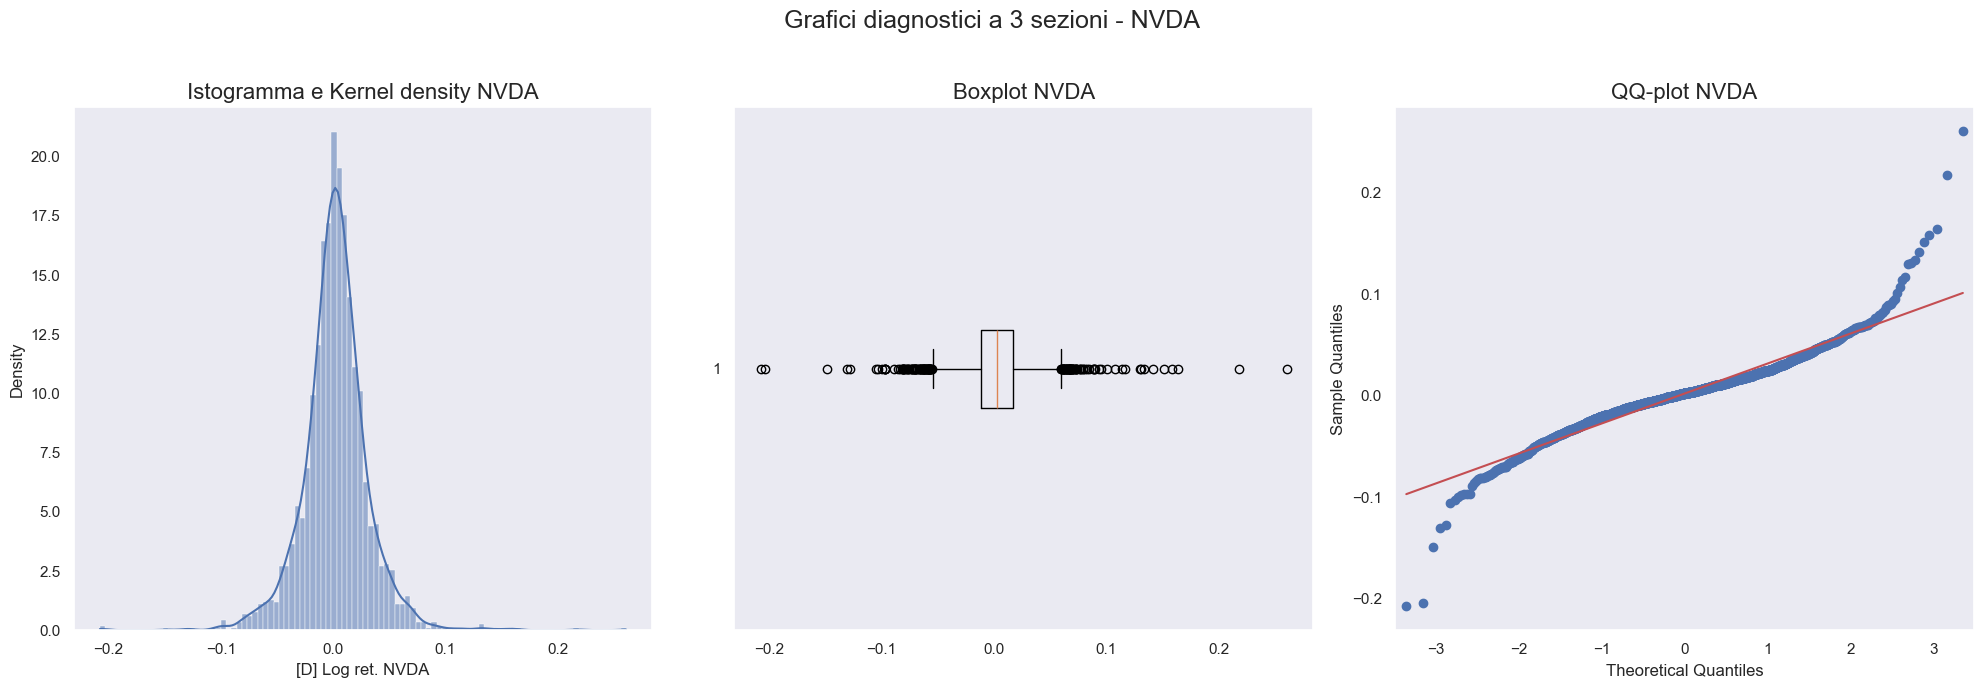

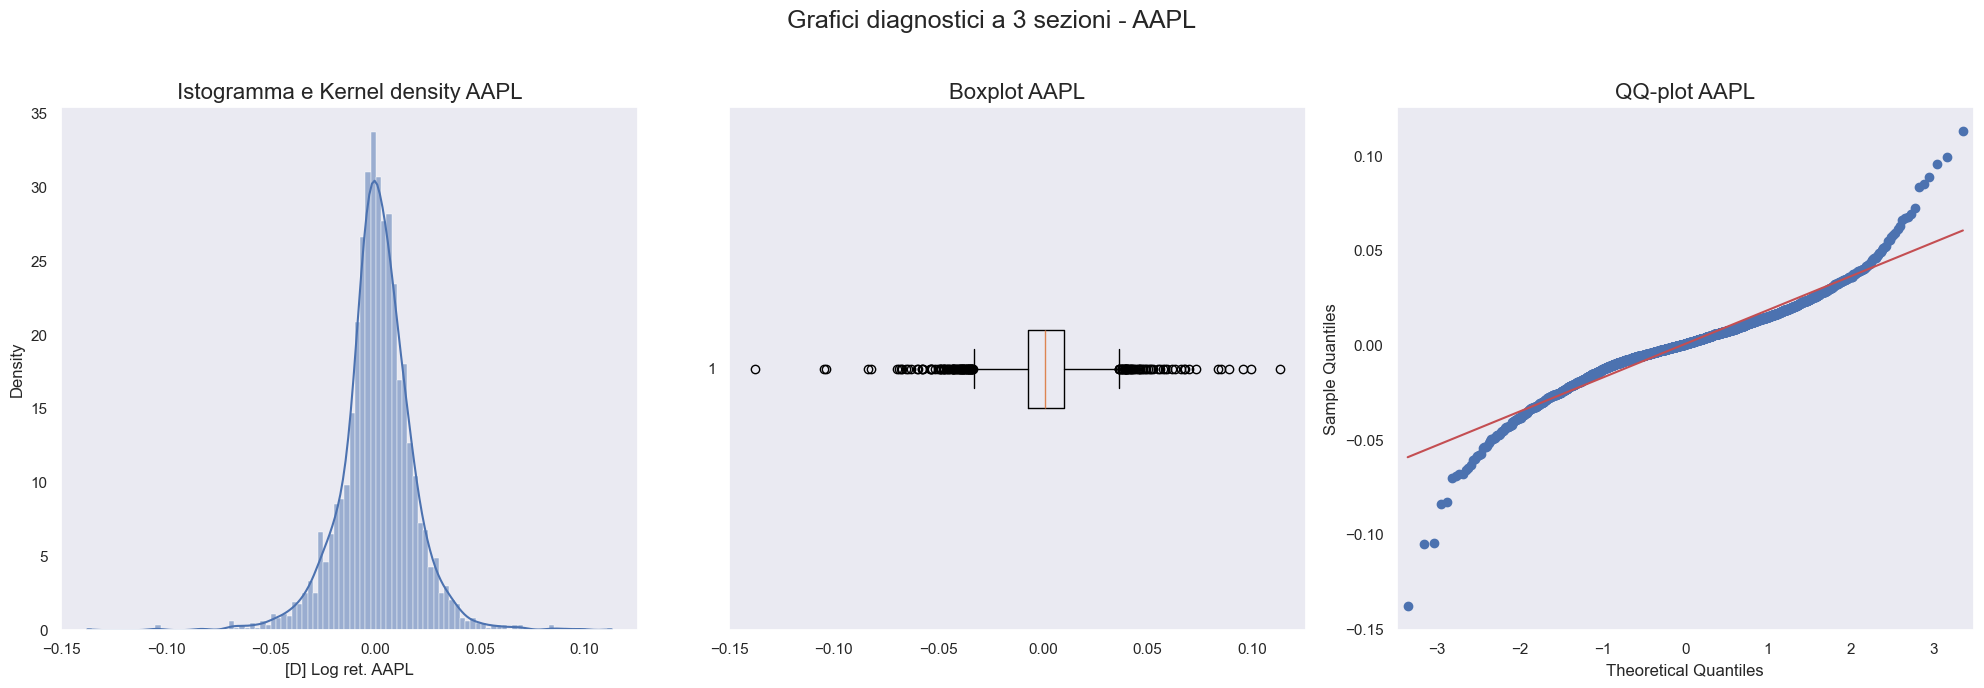

In [24]:
for name in stocks_names:
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    fig.suptitle('Grafici diagnostici a 3 sezioni - ' + name, fontsize=18)
    
    data = daily_log_rtn['[D] Log ret. ' + name]
    
    # Istogramma e kernel density
    axes[0].set_title("Istogramma e Kernel density " + name, fontsize=16)
    sns.histplot(data, kde=True, bins=100, stat="density", ax=axes[0])
    axes[0].grid()
    
    # Boxplot
    axes[1].set_title("Boxplot " + name, fontsize=16)
    axes[1].boxplot(data, vert=False)
    axes[1].grid()
    
    # QQ-plot
    sm.qqplot(data, line='s', ax=axes[2])
    axes[2].set_title("QQ-plot " + name, fontsize=16)
    axes[2].grid()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



In [25]:
# Statistiche descrittive univariate


# Creo una lista per memorizzare le statistiche di ciascun stock
statistics = []

for name in stocks_names:
    data = daily_log_rtn['[D] Log ret. ' + name]
    info = data.describe(include='all')
    mean = round(info[1], 6)
    var = round((info[2] ** 2), 6)
    std = round(info[2], 6)
    skewness = round(data.skew(), 6)
    kurtosis = round(data.kurtosis(), 6)
    
    # Aggiungo le statistiche alla lista
    statistics.append([name, mean, var, std, skewness, kurtosis])

# Creo un DataFrame con le statistiche
stats_df = pd.DataFrame(statistics, columns=['Nome', 'Media', 'Varianza', 'Std. dev.', 'Asimmetria', 'Curtosi'])

# Stampa del DataFrame
print("\n*** Statistiche descrittive univariate ***")
print(stats_df.to_string(index=False))



*** Statistiche descrittive univariate ***
Nome    Media  Varianza  Std. dev.  Asimmetria   Curtosi
 JPM 0.000620  0.000287   0.016953   -0.103432 13.771891
  GS 0.000488  0.000316   0.017780   -0.202517  9.576105
 PFE 0.000152  0.000206   0.014355    0.150338  5.121484
ABBV 0.000585  0.000282   0.016804   -0.942903 12.925626
NVDA 0.002187  0.000874   0.029572    0.248187  7.631919
AAPL 0.000900  0.000318   0.017846   -0.216339  5.515523


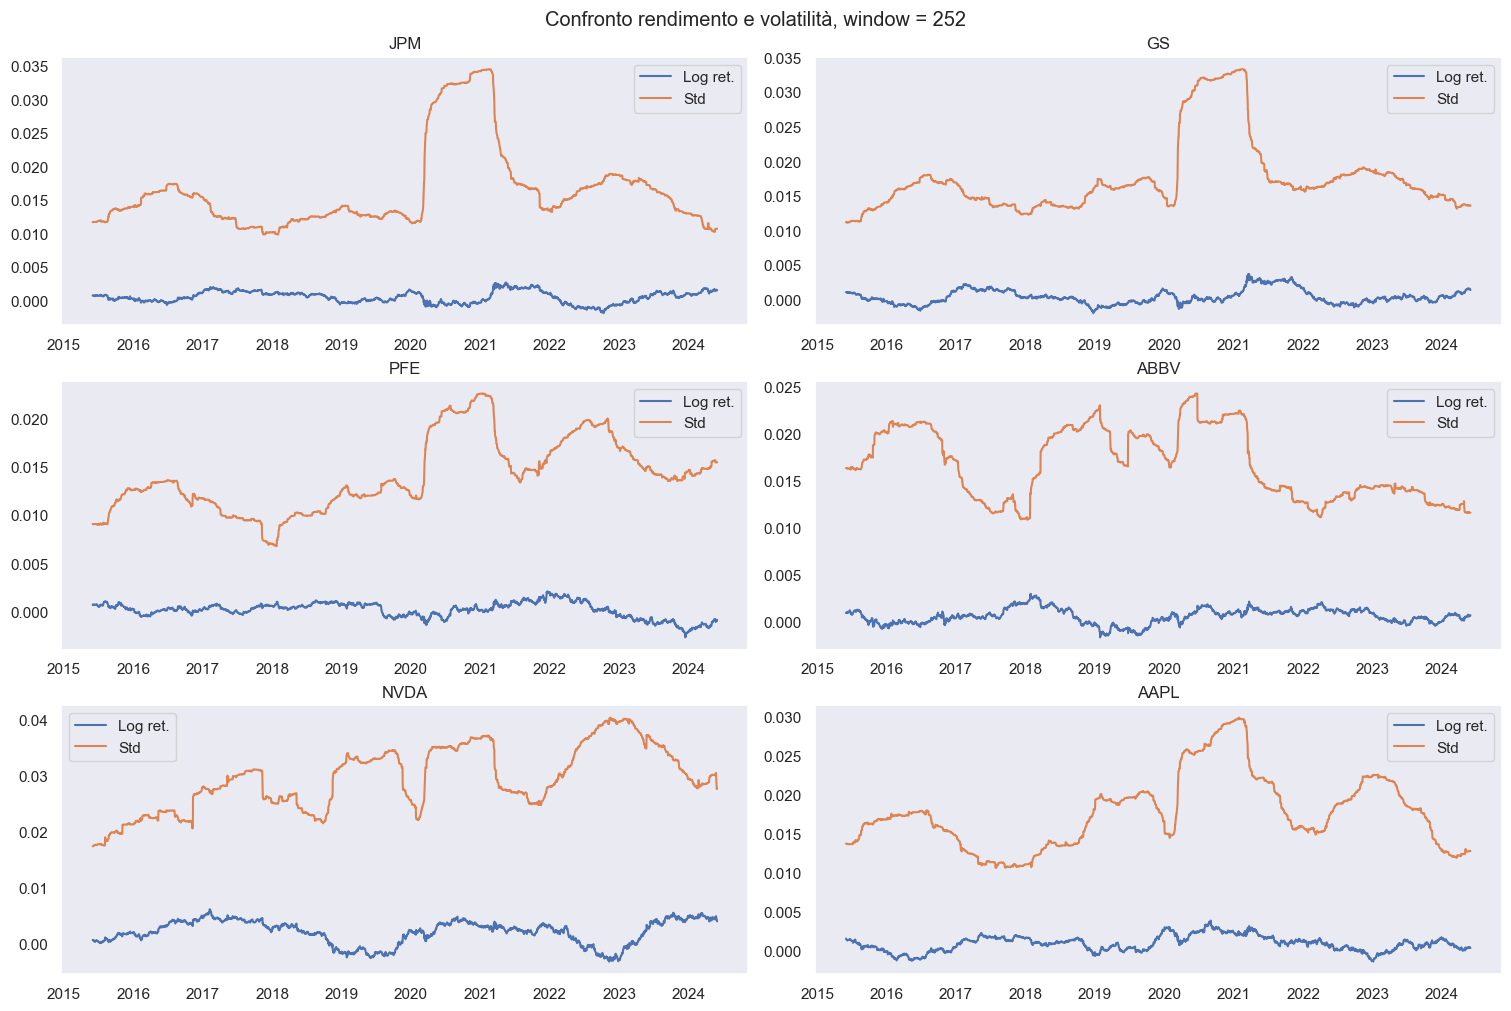

In [26]:
# Confronto nel tempo di rendimento e volatilità

fig = plt.figure(figsize=(15,10), constrained_layout = True)
fig.suptitle('Confronto rendimento e volatilità, window = 252')
for index in range(0, len(stocks_names)):
    name = stocks_names[index]
    plt.subplot(321 + index) # 3 righe, 2 colonne, numero figura (parte da 1)
    plt.title(name)
    plt.plot(daily_log_rtn['[D] Log ret. ' + name].rolling(252).mean())
    plt.plot(daily_log_rtn['[D] Log ret. ' + name].rolling(252).std())
    plt.legend(['Log ret.', 'Std'])
    plt.grid()

JPM        GS       PFE      ABBV      NVDA      AAPL
JPM   0.000287  0.000249  0.000093  0.000103  0.000177  0.000132
GS    0.000249  0.000316  0.000087  0.000099  0.000213  0.000151
PFE   0.000093  0.000087  0.000206  0.000105  0.000082  0.000079
ABBV  0.000103  0.000099  0.000105  0.000282  0.000115  0.000088
NVDA  0.000177  0.000213  0.000082  0.000115  0.000874  0.000291
AAPL  0.000132  0.000151  0.000079  0.000088  0.000291  0.000318

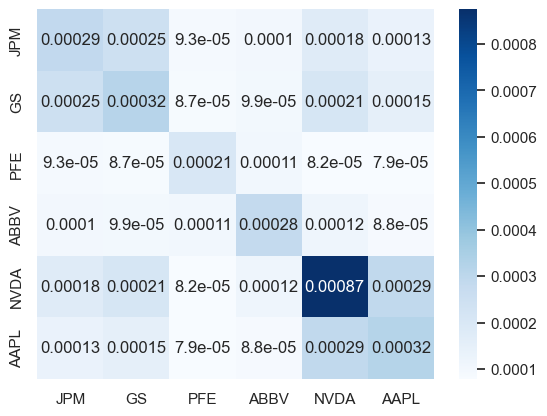

In [27]:
# Matrice di varianze e covarianze

cov_matrix = daily_log_rtn.copy().cov()
cov_matrix.index = stocks_names
cov_matrix.columns = stocks_names

fig, ax = plt.subplots(1,1)
img = sns.heatmap(cov_matrix, annot = True, cmap = 'Blues')

cov_matrix

JPM        GS       PFE      ABBV      NVDA      AAPL
JPM   1.000000  0.825579  0.381404  0.360551  0.352284  0.435876
GS    0.825579  1.000000  0.341868  0.331988  0.404273  0.477110
PFE   0.381404  0.341868  1.000000  0.435850  0.192428  0.308339
ABBV  0.360551  0.331988  0.435850  1.000000  0.232127  0.294903
NVDA  0.352284  0.404273  0.192428  0.232127  1.000000  0.551793
AAPL  0.435876  0.477110  0.308339  0.294903  0.551793  1.000000

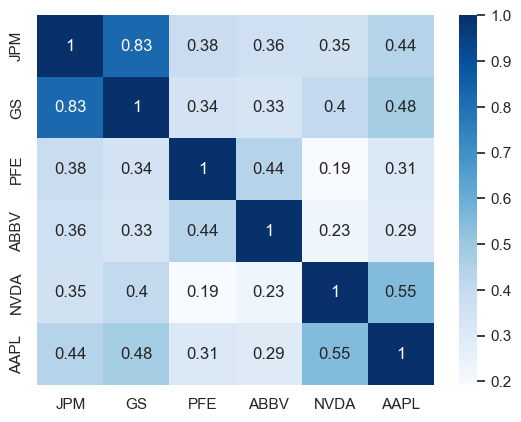

In [28]:
# Matrice di correlazione

corr_matrix = daily_log_rtn.copy().corr()
corr_matrix.index = stocks_names
corr_matrix.columns = stocks_names

fig, ax = plt.subplots(1,1)
img = sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')

corr_matrix

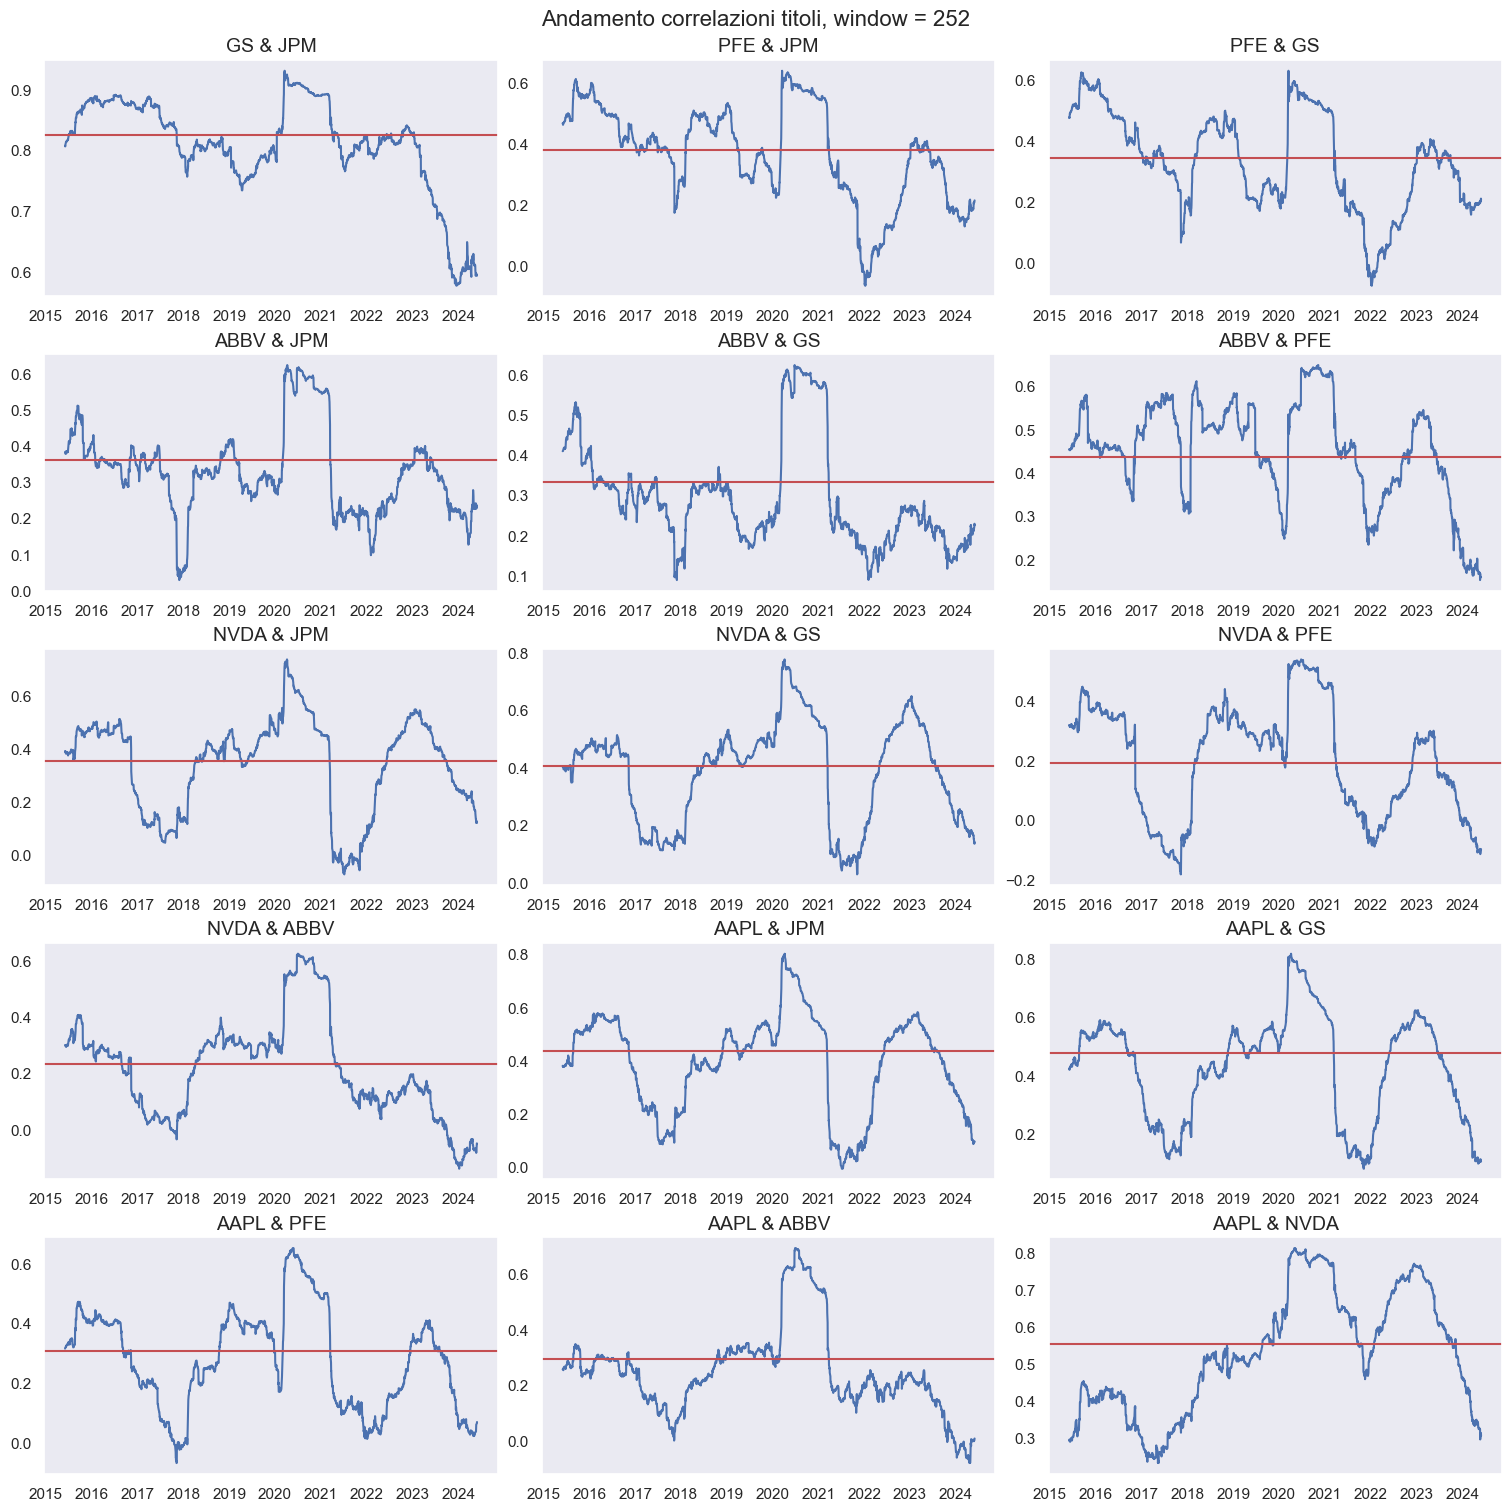

In [29]:
# Andamento di correlazione fra i titoli

(row, col) = (0, 0)

fig, axs = plt.subplots(5, 3, figsize=(15, 15), constrained_layout = True)
    
fig.suptitle('Andamento correlazioni titoli, window = 252', fontsize=16)
# 252 = trading days in un anno

# Prendo il triangolo inferiore della matrice per avere coppie distinte
for i in range(0, 6):
    for j in range(0, i):
        stock_1 = stocks_names[i]
        stock_2 = stocks_names[j]
        
        ax = axs[row, col]
        
        col += 1
        if col == 3:
            col = 0
            row += 1
        
        ax.set_title(stock_1 + ' & ' + stock_2, fontsize=14)
        
        ax.plot(daily_log_rtn['[D] Log ret. ' + stock_1].rolling(window = 252).corr(daily_log_rtn['[D] Log ret. ' + stock_2]))
        # Correlazione su una finestra di 252 days
        
        ax.axhline(corr_matrix.iloc[i, j], c = 'r') # correlazione media
        
        ax.grid()

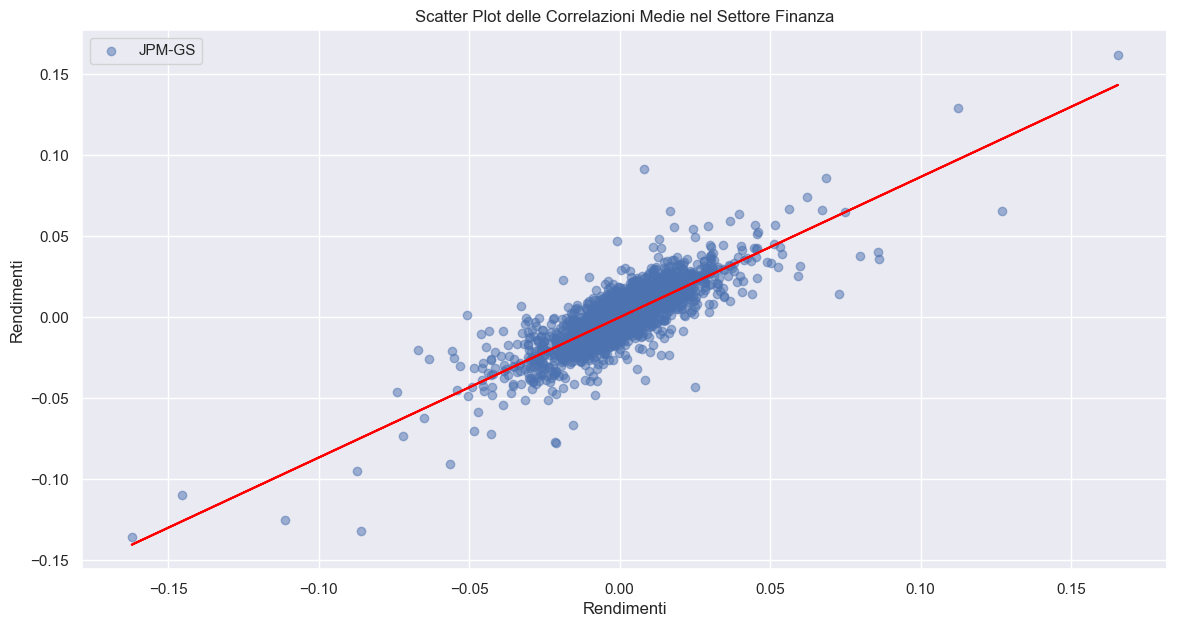

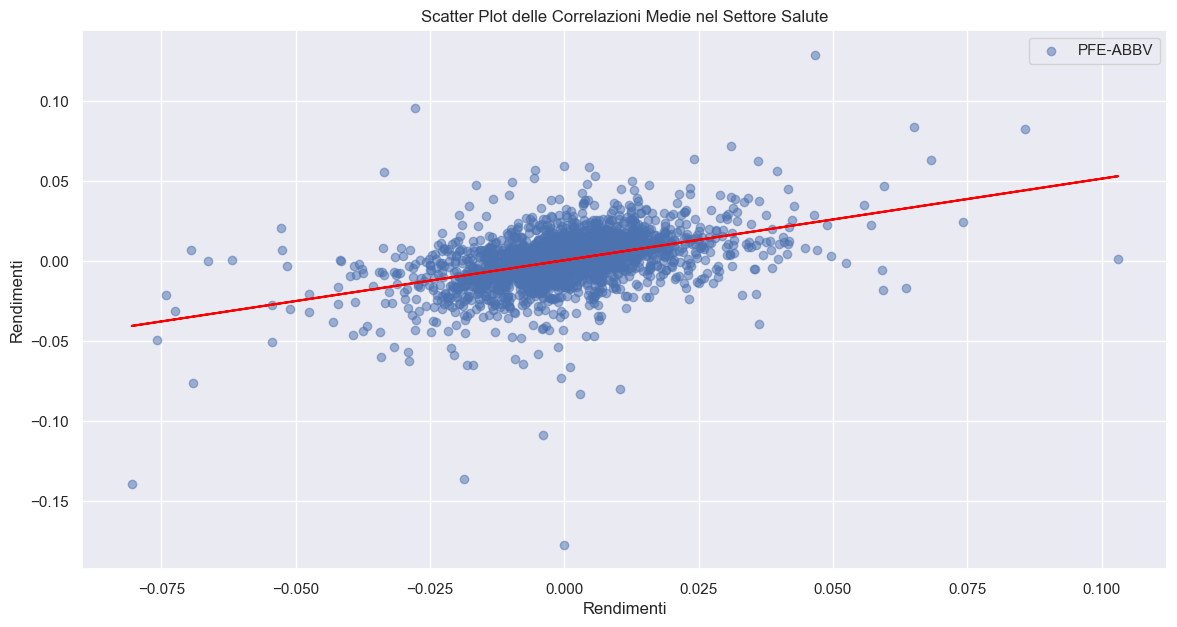

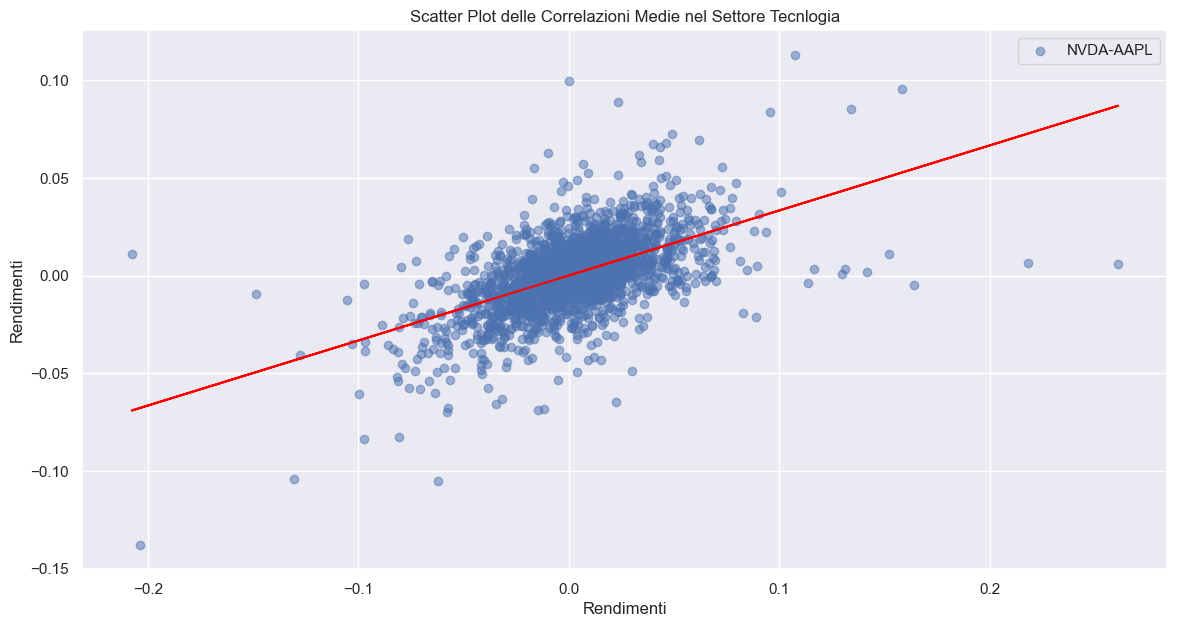

In [30]:
# Grafici di dispersione della correlazione


# Definizione dei settori
settori = {
    'Finanza': ['JPM', 'GS'],
    'Salute': ['PFE', 'ABBV'],
    'Tecnlogia': ['NVDA', 'AAPL']
}

# Funzione per tracciare i grafici di dispersione per ciascun settore
def grafici_dispersione_per_settore(stocks_names, daily_log_rtn, settori):
    for settore, tickers in settori.items():
        plt.figure(figsize=(14, 7))
        for i in range(len(tickers)):
            for j in range(i + 1, len(tickers)):
                stock_1 = tickers[i]
                stock_2 = tickers[j]
                
                x = daily_log_rtn['[D] Log ret. ' + stock_1]
                y = daily_log_rtn['[D] Log ret. ' + stock_2]
                
                plt.scatter(x, y, label=f'{stock_1}-{stock_2}', alpha=0.5)
                
                # Coefficienti retta di regressione
                (m, q) = np.polyfit(x, y, deg=1)
                plt.plot(x, m*x + q, c='red')
                
        plt.title(f'Scatter Plot delle Correlazioni Medie nel Settore {settore}')
        plt.xlabel('Rendimenti')
        plt.ylabel('Rendimenti')
        plt.legend()
        plt.grid(True)
        plt.show()

# Eseguo la funzione
grafici_dispersione_per_settore(stocks_names, daily_log_rtn, settori)


## 3. Analisi di Previsione

In [31]:
# adj_close mensile, lo utilizzo più avanti varie volte
adj_closes_m = adj_closes.resample('M').last()
adj_closes_m.head()

Adj Close_JPM  Adj Close_GS  Adj Close_PFE  Adj Close_ABBV  \
Date                                                                     
2014-06-30      43.380898    138.056656      19.215277       37.394096   
2014-07-31      43.722084    142.533783      18.744743       34.940701   
2014-08-31      45.071568    148.136719      19.195395       36.903366   
2014-09-30      45.670498    151.825546      19.312960       38.558933   
2014-10-31      46.161385    157.135269      19.561148       42.680134   

            Adj Close_NVDA  Adj Close_AAPL  
Date                                        
2014-06-30        0.441223       20.549961  
2014-07-31        0.416473       21.140394  
2014-08-31        0.464927       22.778954  
2014-09-30        0.441023       22.390051  
2014-10-31        0.467079       24.001242

In [32]:
# grid_search

def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0
    for order in param_combinations:
        for (p, q, d) in param_combinations:
            seasonal_order = (p, q, d, s)
            total_iterations += 1
            try:
                model = SARIMAX(dataframe, order = order,
                               seasonal_order=seasonal_order
                               )
                model_result = model.fit()
                
                if lowest_aic is None or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            
            except Exception as ex:
                continue
                
    return lowest_aic, pdq, pdqs

In [33]:
# La funzione che esegue il test adfuller per controllare la stazionarietà

def my_adfuller(series):
    tmp = adfuller(series)
    print("Statistica del test: " + str(tmp[0]))
    print("p-value: " + str(tmp[1]))
    print("Numero di lag utilizzati: " + str(tmp[2]))
    print("Numero di osservazioni: " + str(tmp[3]))
    print("Valori critici per la statistica: ", tmp[4])
    
    if tmp[1] <= 0.05 and tmp[0] <= tmp[4]['5%']:
        print("\nRisultato: stazionaria")
    else:
        print("\nRisultato: non-stazionaria")

In [34]:
#Riscrivo in modo corretto

def m_adj(name):
    return adj_closes_m['Adj Close_' + name]

### Trend, seasonal e resid

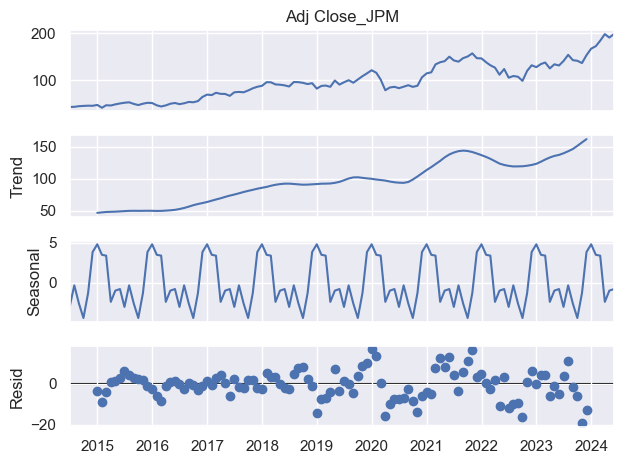

In [35]:
decompose = seasonal_decompose(m_adj(stocks_names[0]))
decompose.plot();

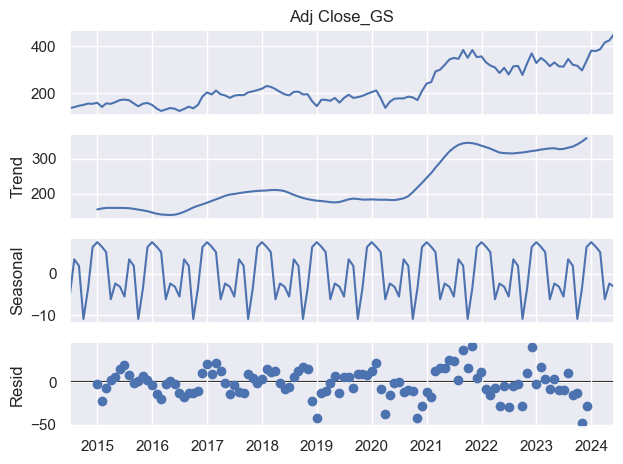

In [36]:
decompose = seasonal_decompose(m_adj(stocks_names[1]))
decompose.plot();

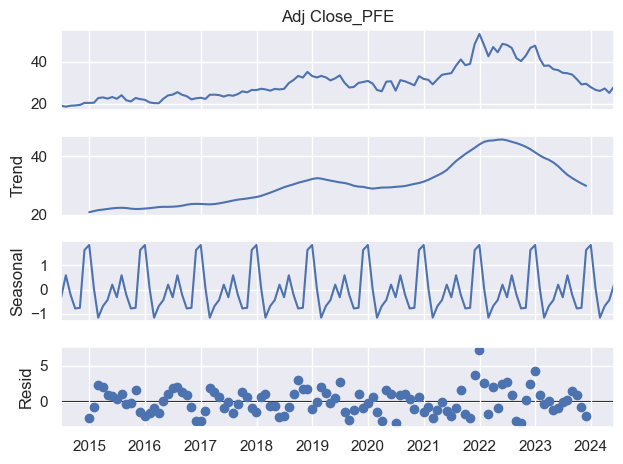

In [37]:
decompose = seasonal_decompose(m_adj(stocks_names[2]))
decompose.plot();

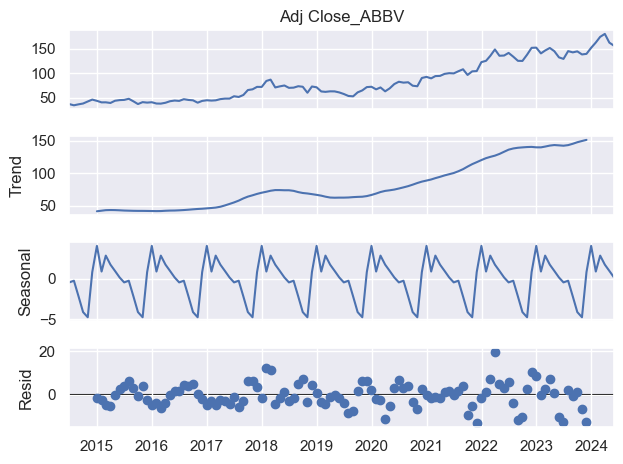

In [38]:
decompose = seasonal_decompose(m_adj(stocks_names[3]))
decompose.plot();

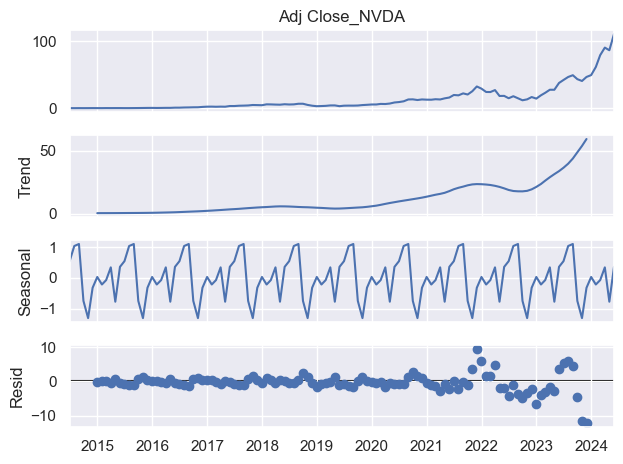

In [39]:
decompose = seasonal_decompose(m_adj(stocks_names[4]))
decompose.plot();

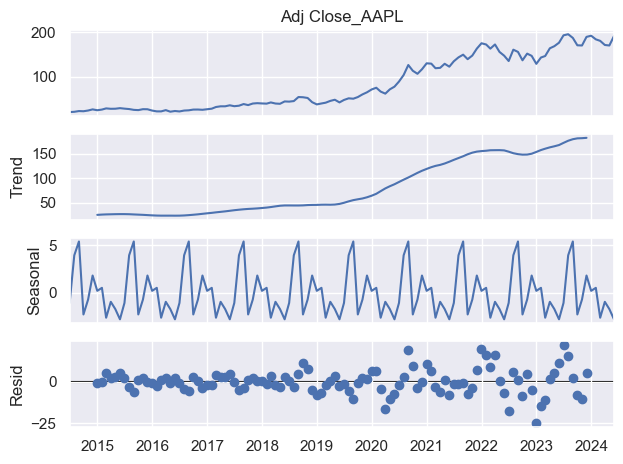

In [40]:
decompose = seasonal_decompose(m_adj(stocks_names[5]))
decompose.plot();

### Grid search


In [ ]:
hyperparams = dict([])

for name in stocks_names:

    hyperparams.update({name:arima_grid_search(m_adj(name)[:110], 12)}) # training + validation
    
print("OK!")

In [42]:
pp = pprint.PrettyPrinter(sort_dicts=False)
pp.pprint(hyperparams)

# AIC, order, seasonal_oder

{'JPM': (677.0131207032246, (0, 1, 0), (1, 1, 1, 12)),
 'GS': (867.0818599586154, (0, 1, 0), (0, 1, 1, 12)),
 'PFE': (445.404689240587, (0, 1, 0), (0, 1, 1, 12)),
 'ABBV': (655.3602049219121, (0, 1, 0), (0, 1, 1, 12)),
 'NVDA': (443.12237199247215, (1, 1, 1), (0, 1, 1, 12)),
 'AAPL': (693.4424675950875, (0, 1, 0), (0, 1, 1, 12))}


### Creazione e fit modelli SARIMAX

In [43]:
models = dict([])

for name in stocks_names:
    training_set = m_adj(name)[:80]
    
    model_results = SARIMAX(
        training_set,
        order=hyperparams.get(name)[1],
        seasonal_order=hyperparams.get(name)[2]
    ).fit()
    
    models.update({name:model_results})
    
print("OK!")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.79580D+00    |proj g|=  3.87371D-02

At iterate    5    f=  2.72658D+00    |proj g|=  5.29849D-02

At iterate   10    f=  2.72120D+00    |proj g|=  5.10801D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   3.617D-06   2.721D+00
  F =   2.7212017006445306     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.54267D+00    |proj g|=  1.38152D-02

At iterate   10    f=  3.54148D+00    |proj g|=  4.53264D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   4.533D-06   3.541D+00
  F =   3.5414842555265471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87757D+00    |proj g|=  1.91217D-01

At iterate    5    f=  1.70968D+00    |proj g|=  1.71483D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     21      1     0     0   2.180D-06   8.699D-01
  F =  0.86994025340931580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82380D+00    |proj g|=  8.73197D-02

At iterate    5    f=  2.68457D+00    |proj g|=  2.37813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


In [44]:
# summary

for (k,v) in models.items():
    print("==== SUMMARY " + k + " ====\n")
    print(v.summary())
    print("\n\n\n\n\n")

==== SUMMARY JPM ====

                                      SARIMAX Results                                       
Dep. Variable:                        Adj Close_JPM   No. Observations:                   80
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -217.696
Date:                              Fri, 12 Jul 2024   AIC                            441.392
Time:                                      17:04:34   BIC                            448.006
Sample:                                  06-30-2014   HQIC                           444.009
                                       - 01-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1509      0.273     -0.552      0.581      -0.686       0.

### Residui standardizzati


#### Residui JPM

In [45]:
name = stocks_names[0] # JPM

print("Residui " + name)

models.get(name).resid.describe()

Residui JPM


count    80.000000
mean      0.448268
std       7.802244
min     -20.285313
25%      -2.701437
50%       0.416037
75%       3.444069
max      43.380898
dtype: float64

Residui JPM


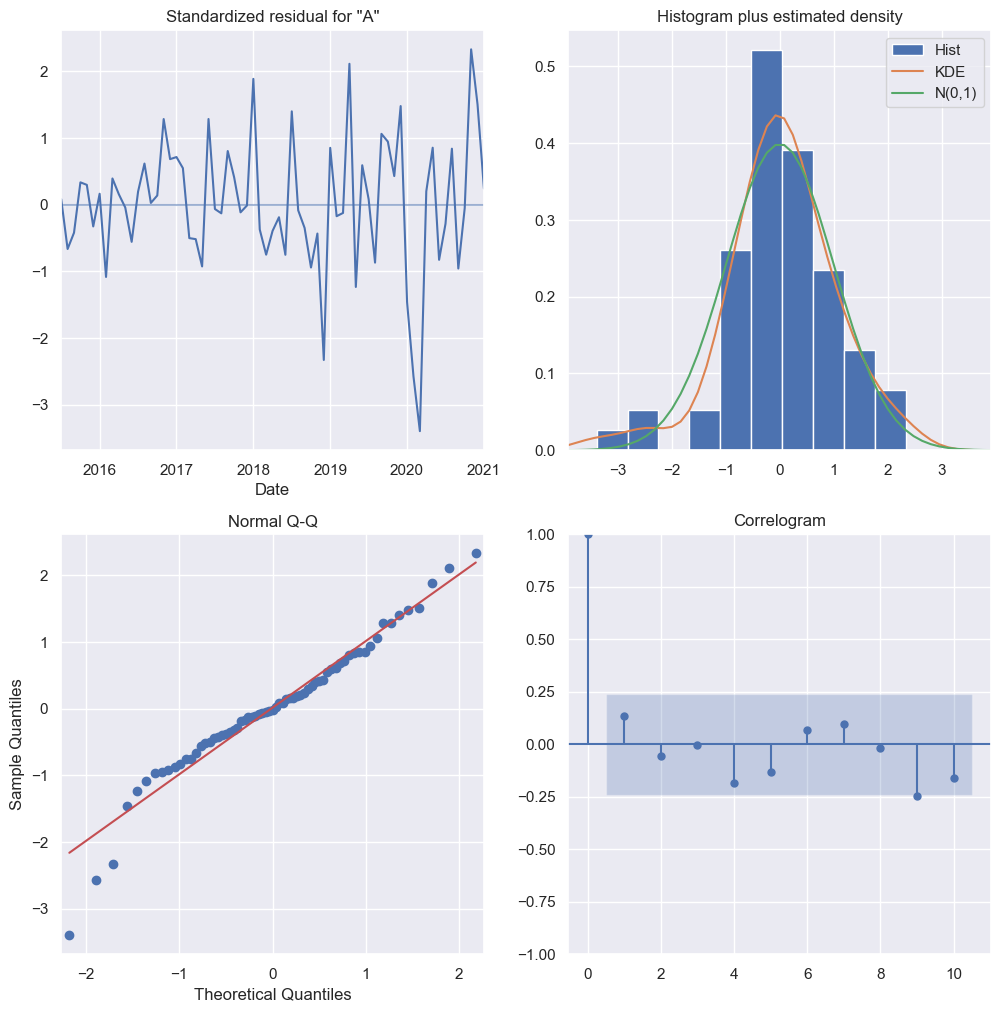

In [46]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 12));

#### Rendimenti GS

In [47]:
name = stocks_names[1] # GS

print("Residui " + name)

models.get(name).resid.describe()

Residui GS


count     80.000000
mean       1.173232
std       23.020977
min      -66.858203
25%      -11.329651
50%        0.705797
75%        8.780714
max      138.056656
dtype: float64

Residui GS


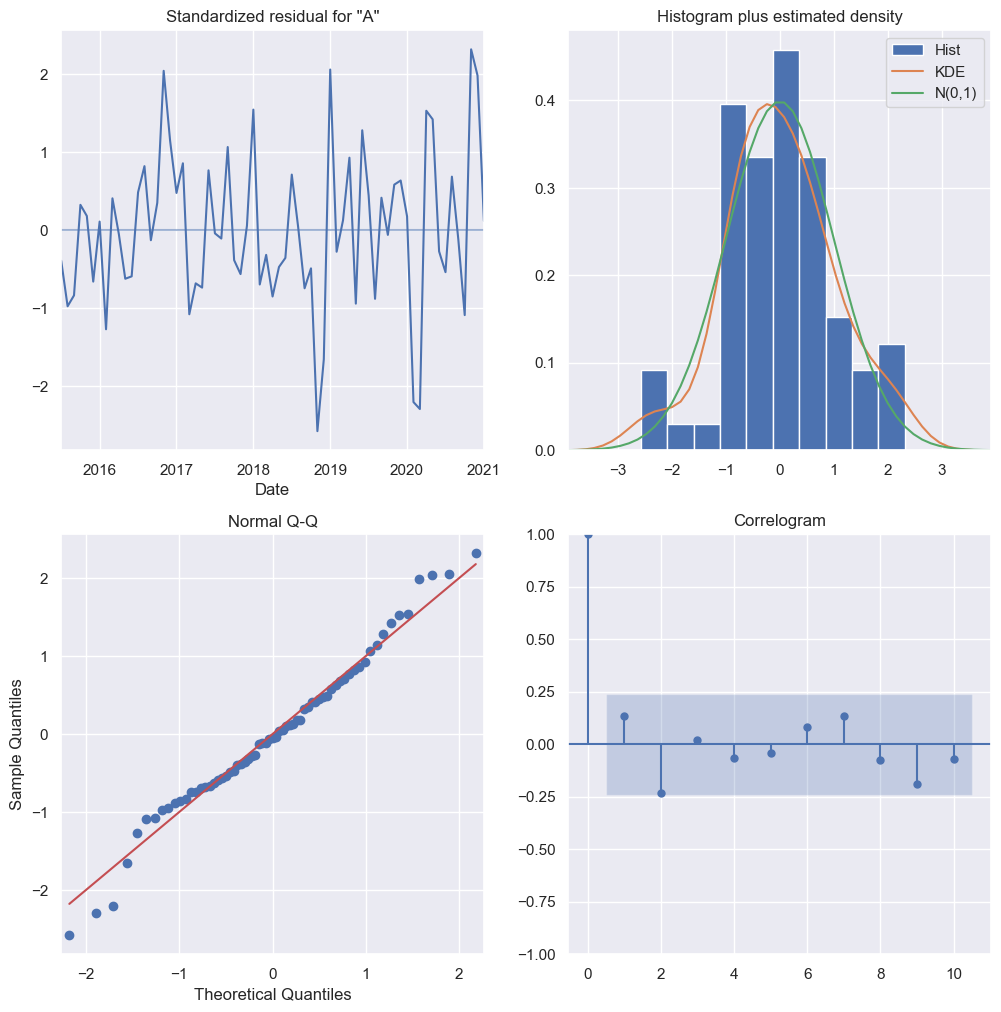

In [48]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 12));

#### Residui PFE

In [49]:
name = stocks_names[2] # PFE

print("Residui " + name)

models.get(name).resid.describe()

Residui PFE


count    80.000000
mean      0.113238
std       2.977615
min     -10.425157
25%      -0.814315
50%      -0.009437
75%       0.943199
max      19.215277
dtype: float64

Residui PFE


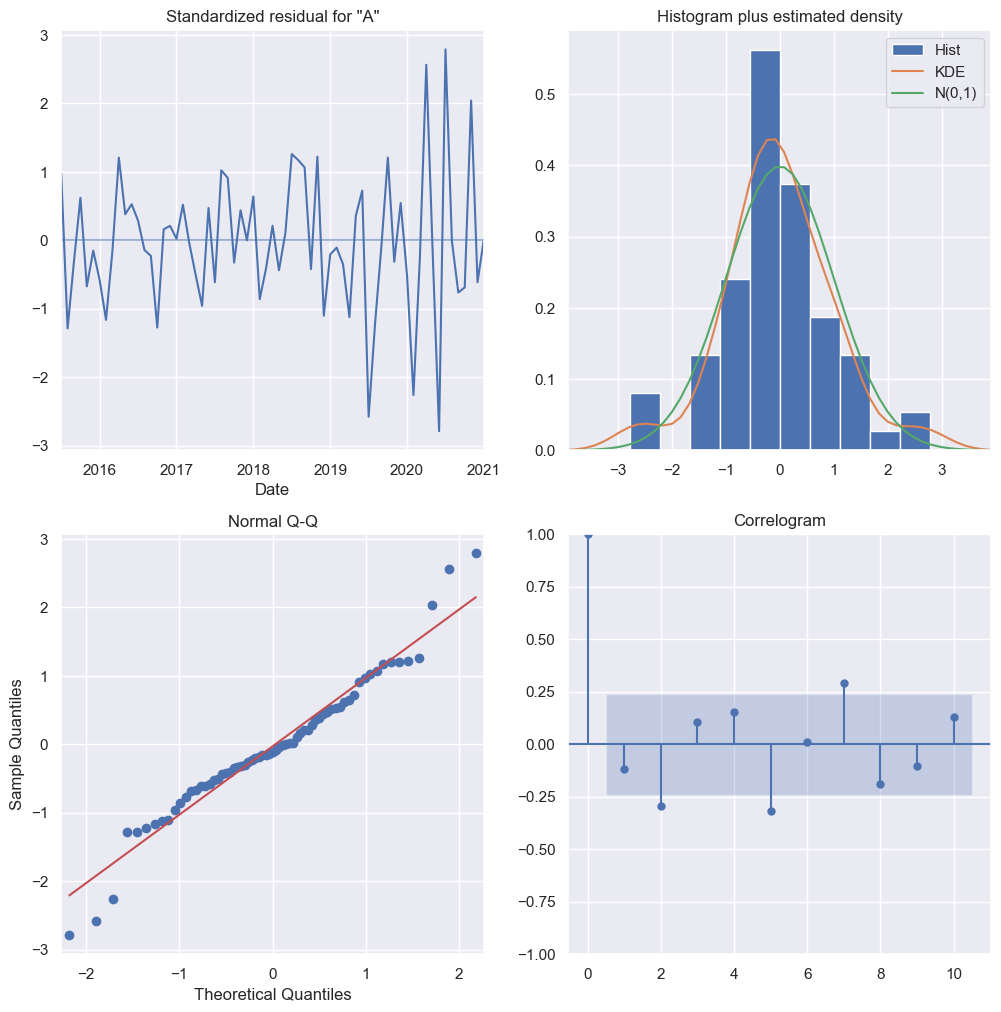

In [50]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 12));

#### Residui ABBV

In [51]:
name = stocks_names[3] # ABBV

print("Residui " + name)

models.get(name).resid.describe()

Residui ABBV


count    80.000000
mean      0.458106
std       6.935014
min     -18.287106
25%      -2.472243
50%       0.273432
75%       3.138926
max      37.394096
dtype: float64

Residui ABBV


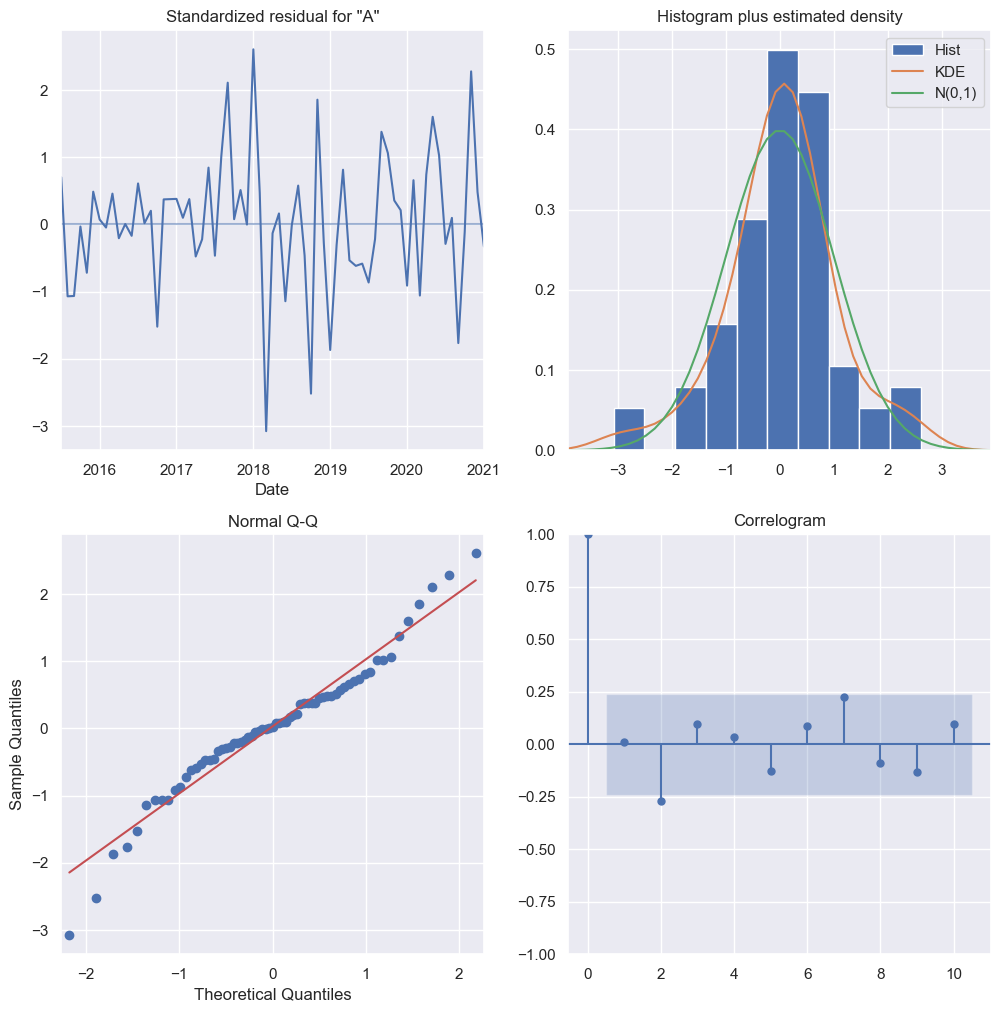

In [52]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 12));

#### Residui NVDA

In [53]:
name = stocks_names[4] # NVDA

print("Residui " + name)

models.get(name).resid.describe()

Residui NVDA


count    80.000000
mean      0.091864
std       0.586709
min      -1.855313
25%      -0.150130
50%       0.028040
75%       0.292195
max       2.339865
dtype: float64

Residui NVDA


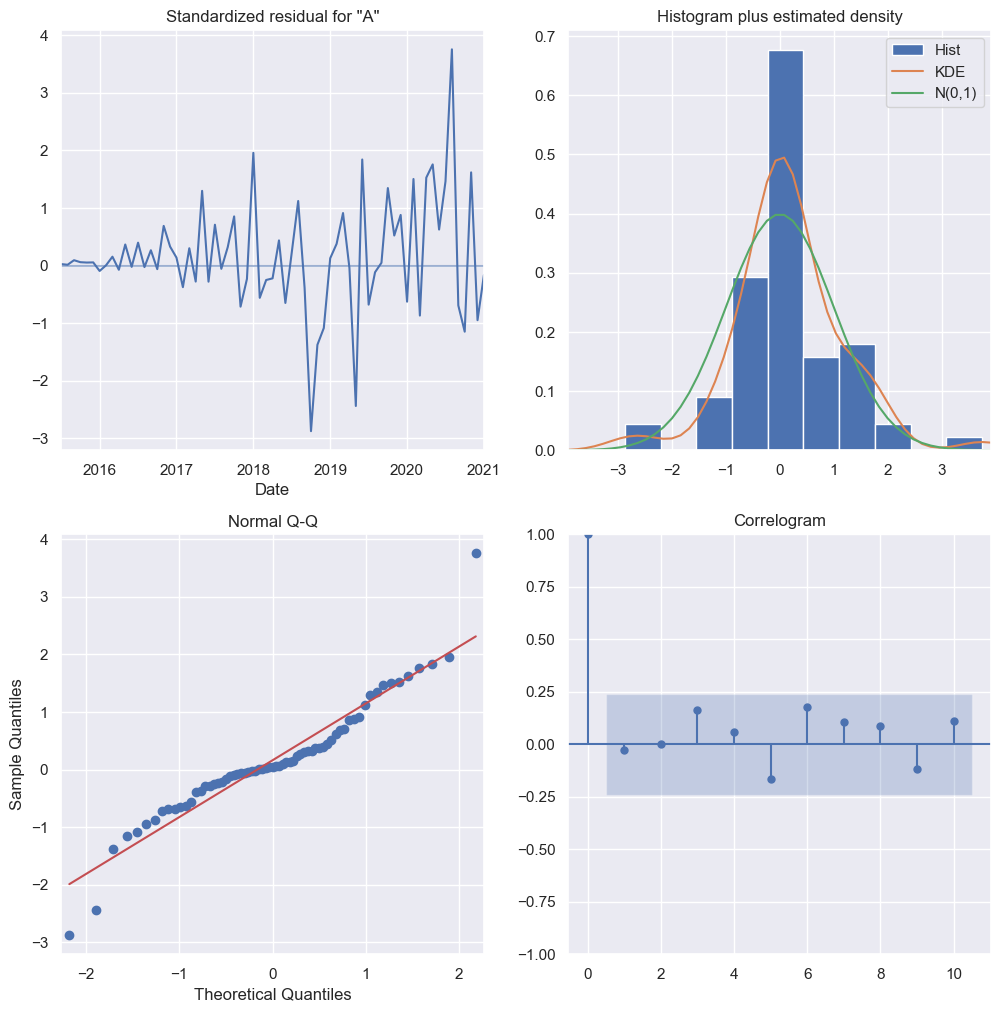

In [54]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 12));

#### Residui AAPL

In [55]:
name = stocks_names[5] # AAPL

print("Residui " + name)

models.get(name).resid.describe()

Residui AAPL


count    80.000000
mean      0.978745
std       5.943668
min     -14.487883
25%      -1.584964
50%       0.529387
75%       2.932117
max      20.549961
dtype: float64

Residui AAPL


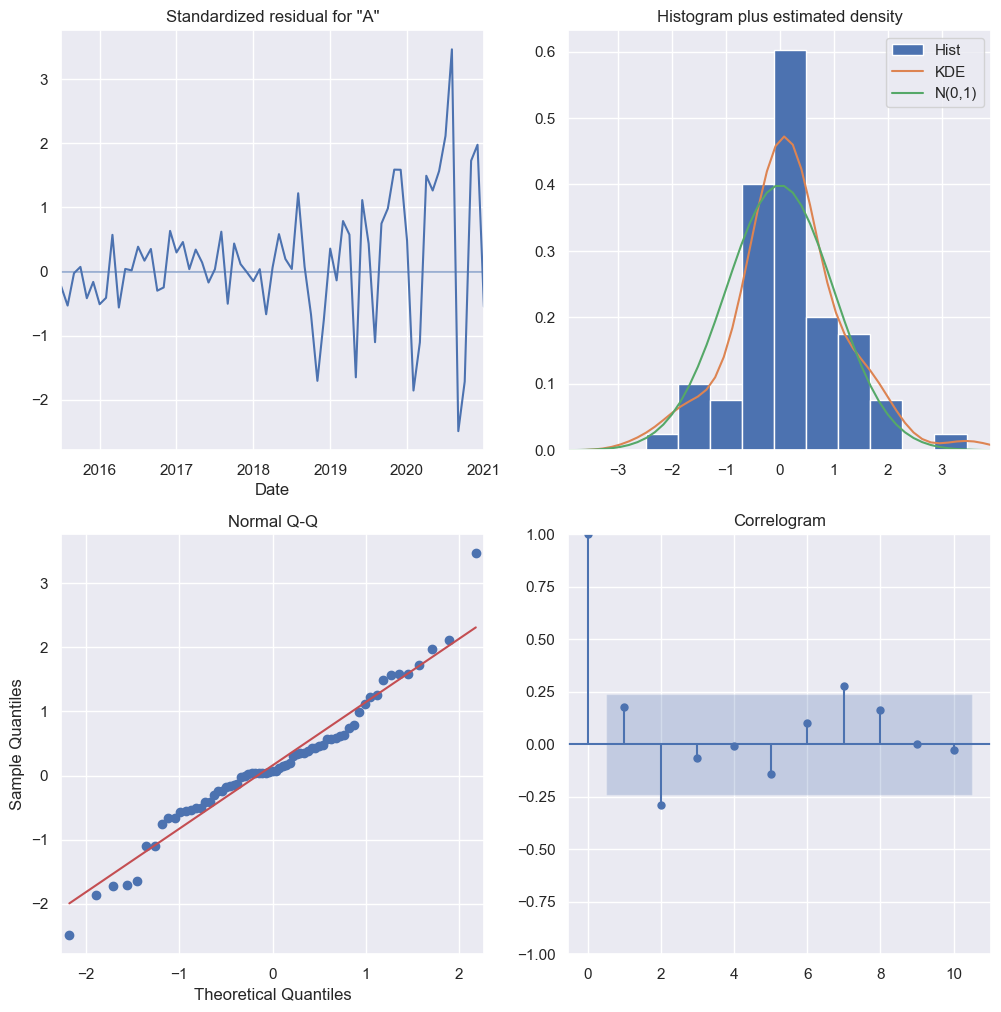

In [56]:
print("Residui " + name)
models.get(name).plot_diagnostics(figsize=(12, 12));

### Predizione su ultimi 10 mesi

In [57]:
predictions_ic = dict([]) # intervalli di confidenza
forecasted_vals = dict([]) # valori

for name in stocks_names:
    prediction_ci = models.get(name).get_prediction(start=110, end = 110+9).conf_int() # i.c. di 10 predizioni
    forecasted_val = models.get(name).predict(start=110, end = 110+9) # valori forecasted per gli ultimi 10 mesi
    
    predictions_ic.update({name:prediction_ci})
    forecasted_vals.update({name:forecasted_val})

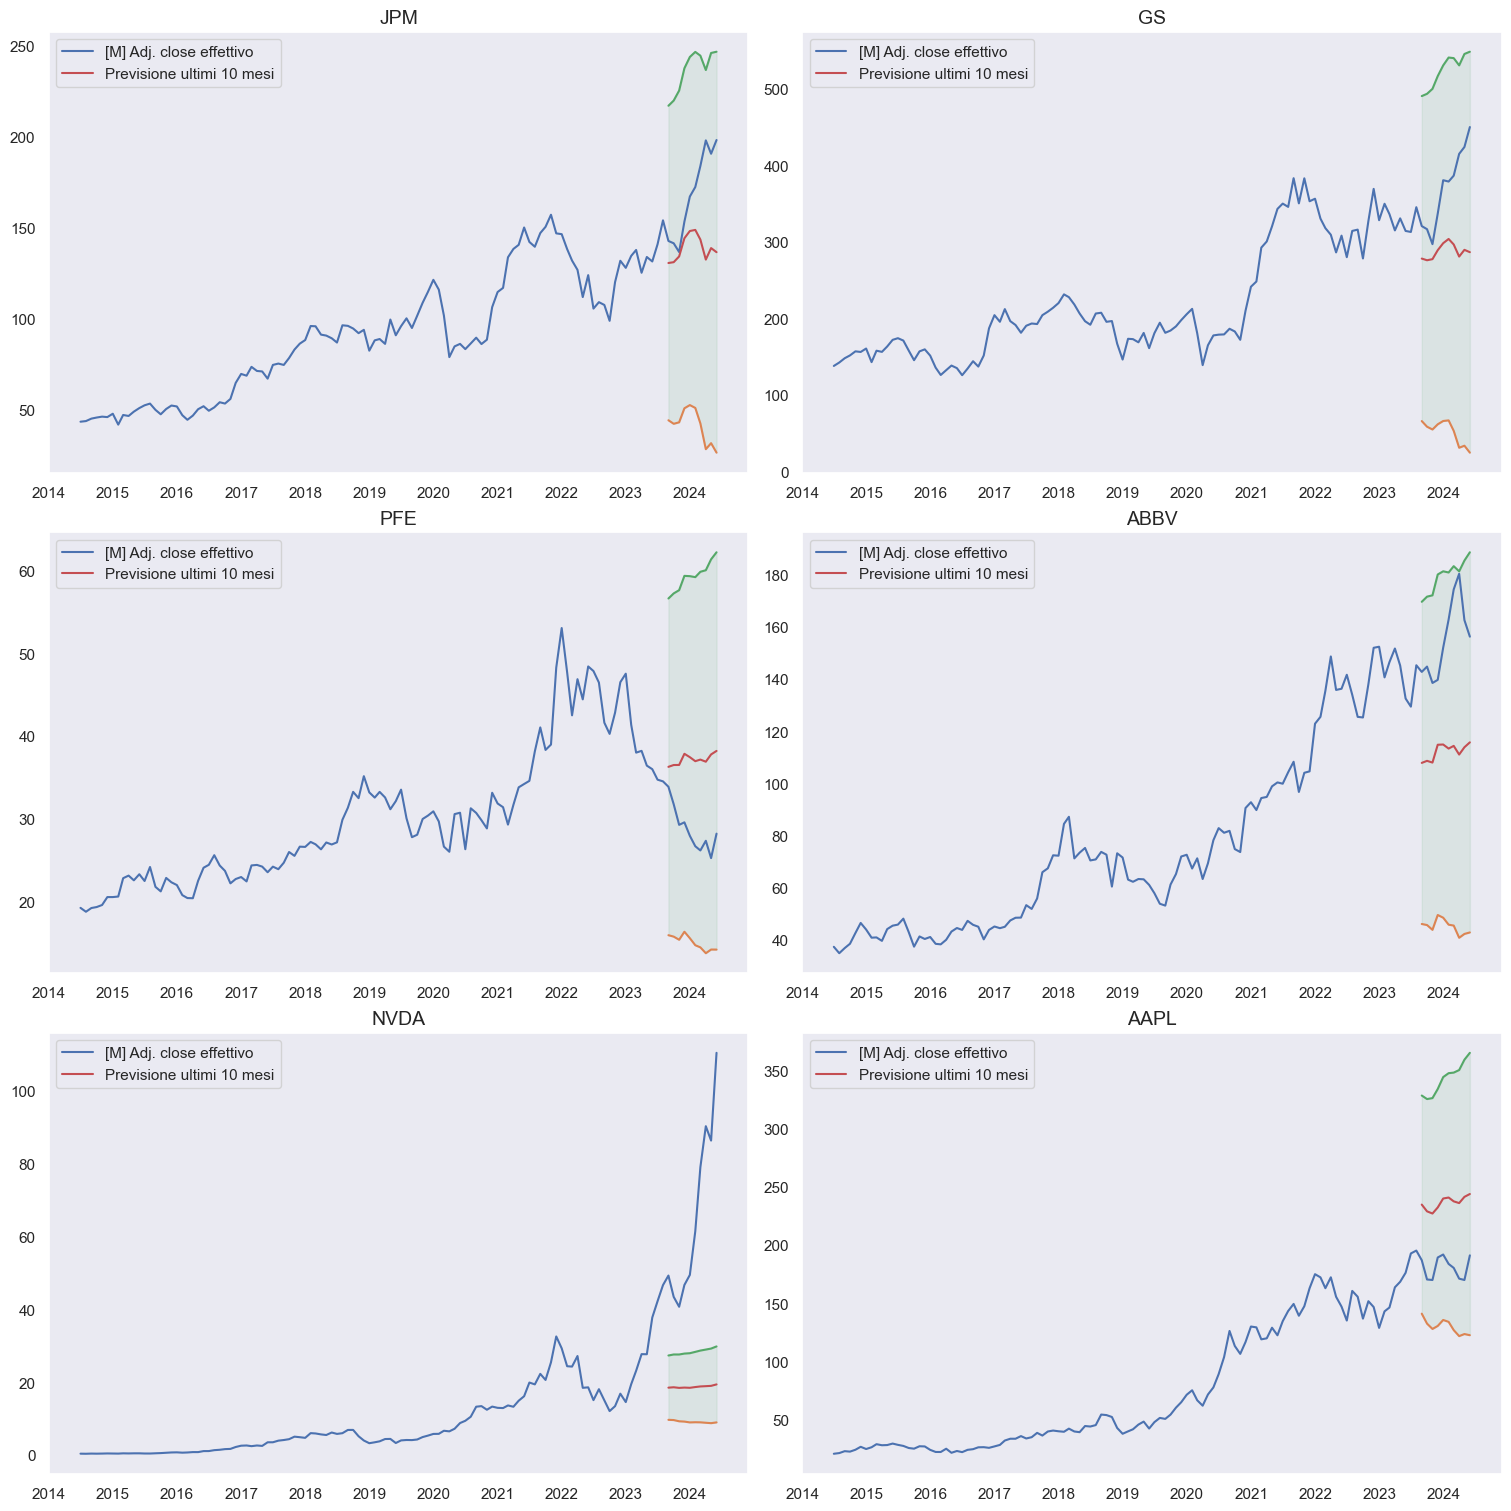

In [58]:
(row, col) = (0, 0)

fig, axs = plt.subplots(3, 2, figsize=(15, 15), constrained_layout = True)

for name in stocks_names:
    ax = axs[row, col]
        
    col += 1
    if col == 2:
        col = 0
        row += 1
        
    ax.set_title(name, fontsize=14)
    
    ax.plot(m_adj(name), label = '[M] Adj. close effettivo')
    
    # intervallo di confidenza
    ax.plot(predictions_ic.get(name))
    ax.fill_between(predictions_ic.get(name).index, 
                    predictions_ic.get(name).iloc[:,0], 
                    predictions_ic.get(name).iloc[:,1], 
                    color = 'g', alpha = 0.1)
    
    # forecast ultimi 10 mesi
    ax.plot(forecasted_vals.get(name), label='Previsione ultimi 10 mesi')
    
    
    ax.grid()
    ax.legend()

### Calcolo di MSE e RMSE, ultimi 10 mesi

In [59]:
# mse e rmse

for name in stocks_names:
    print("------- MSE e RMSE " + name + " -------\n")
    mse = mean_squared_error(m_adj(name)[-10:], forecasted_vals.get(name))
    rmse = sqrt(mse)
    
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    
    print("\n\n")

------- MSE e RMSE JPM -------

MSE:  1368.1107800412942
RMSE:  36.98798156214116



------- MSE e RMSE GS -------

MSE:  8940.681244232848
RMSE:  94.55517566073709



------- MSE e RMSE PFE -------

MSE:  81.73719995854567
RMSE:  9.040862788392802



------- MSE e RMSE ABBV -------

MSE:  2032.1212831533303
RMSE:  45.07905592571045



------- MSE e RMSE NVDA -------

MSE:  2718.472315874188
RMSE:  52.138971181585354



------- MSE e RMSE AAPL -------

MSE:  3185.943834454979
RMSE:  56.44416563698129





## 4. Strategie di trading e backtesting

Utilizzo le bande di bollinger + RSI.
    
- Quando il prezzo esce dalla banda superiore e poi vi rientra + RSI > 70 si ha un segnale di vendita (overbought)
- Quando esce dalla banda inferiore e successivamente rientra + RSI < 30 ho un segnale di acquisto (oversold)

In [60]:
# asset che utilizzo

name = 'PFE'

# parametri per gli indicatori

# BB
G = 20
F = 2

# RSI
rsi_upper = 70
rsi_lower = 30

# preparazione dataframe

data = pd.DataFrame()

data['Adj Close'] = adj_closes['Adj Close_' + name]

# calcolo BB

rolling = data['Adj Close'].rolling(G)

data['upper_band'] = rolling.mean() + F * rolling.std()
data['lower_band'] = rolling.mean() - F * rolling.std()

# calcolo RSI

delta = data['Adj Close'].diff(1)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

avg_gain = up.rolling(window = G).mean()

avg_loss = abs(down.rolling(window = G).mean())

rs = avg_gain / avg_loss

data['rsi'] = 100.0 - (100.0 / (1.0 + rs))

In [61]:
data.tail()

Adj Close  upper_band  lower_band        rsi
Date                                                    
2024-05-23  28.690001   30.305941   25.164223  74.796255
2024-05-24  28.879999   30.203855   25.652045  74.966162
2024-05-28  28.299999   29.980519   26.179474  68.843872
2024-05-29  27.820000   29.571872   26.846184  65.128481
2024-05-30  28.200001   29.465043   27.095394  59.656569

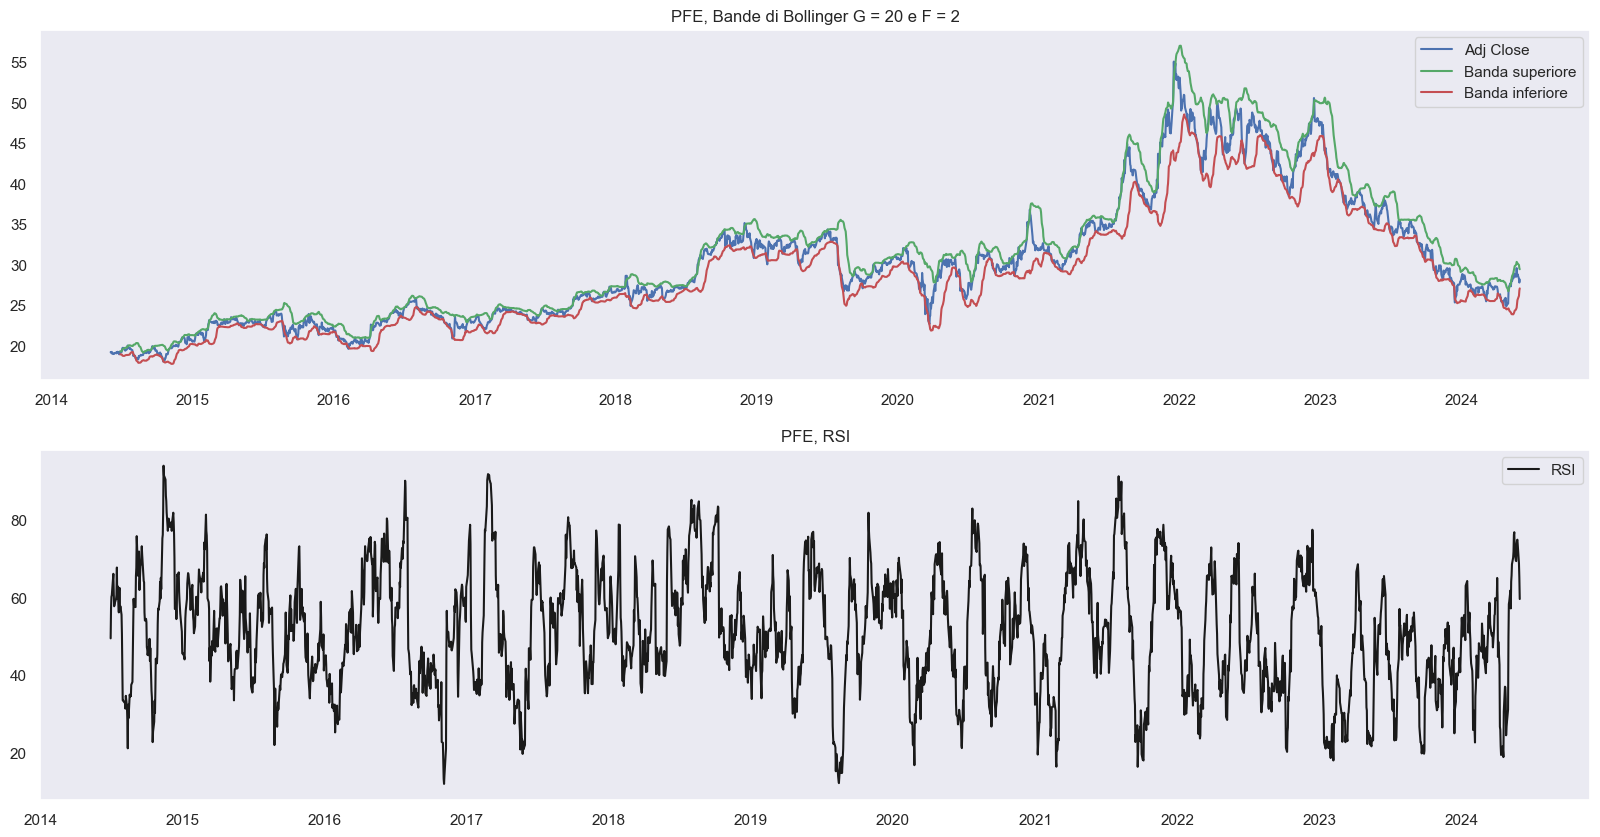

In [62]:
plt.figure(figsize=(20,10))

plt.subplot(211)
plt.title(name + ', Bande di Bollinger G = ' + str(G) + ' e F = ' + str(F))
plt.plot(data['Adj Close'], label = 'Adj Close')
plt.plot(data['upper_band'], label = 'Banda superiore', color = 'g')
plt.plot(data['lower_band'], label = 'Banda inferiore', color = 'r')
plt.grid()
plt.legend()

plt.subplot(212)
plt.title(name + ', RSI')
plt.plot(data['rsi'], label = 'RSI', color = 'k')
plt.grid()
plt.legend();

In [63]:
# backtesting

# acquisto
data['signal'] = np.where(((data['rsi'] < rsi_lower) 
                           & (data['Adj Close'] < data['lower_band']) 
                           & (data['Adj Close'].shift(1) > data['lower_band'])),
                          1, 0)

# vendita
data['signal'] = np.where((data['rsi'] > rsi_upper)
                          & (data['Adj Close'] > data['upper_band']) 
                          & (data['Adj Close'].shift(1) < data['upper_band']),
                          -1, data['signal'])

# posizioni, rimpiazzo gli 0 con il primo valore precedente diverso da 0
data['position'] = data['signal'].replace(to_replace=0, method='ffill')

# shift perche' poi calcolo i rendimenti
data['position'] = data['position'].shift(1)

print("Segnale (1 = buy, -1 = sell) e numero di segnali di quel tipo:")
data['signal'].value_counts()

Segnale (1 = buy, -1 = sell) e numero di segnali di quel tipo:


signal
 0    2443
-1      50
 1      24
Name: count, dtype: int64

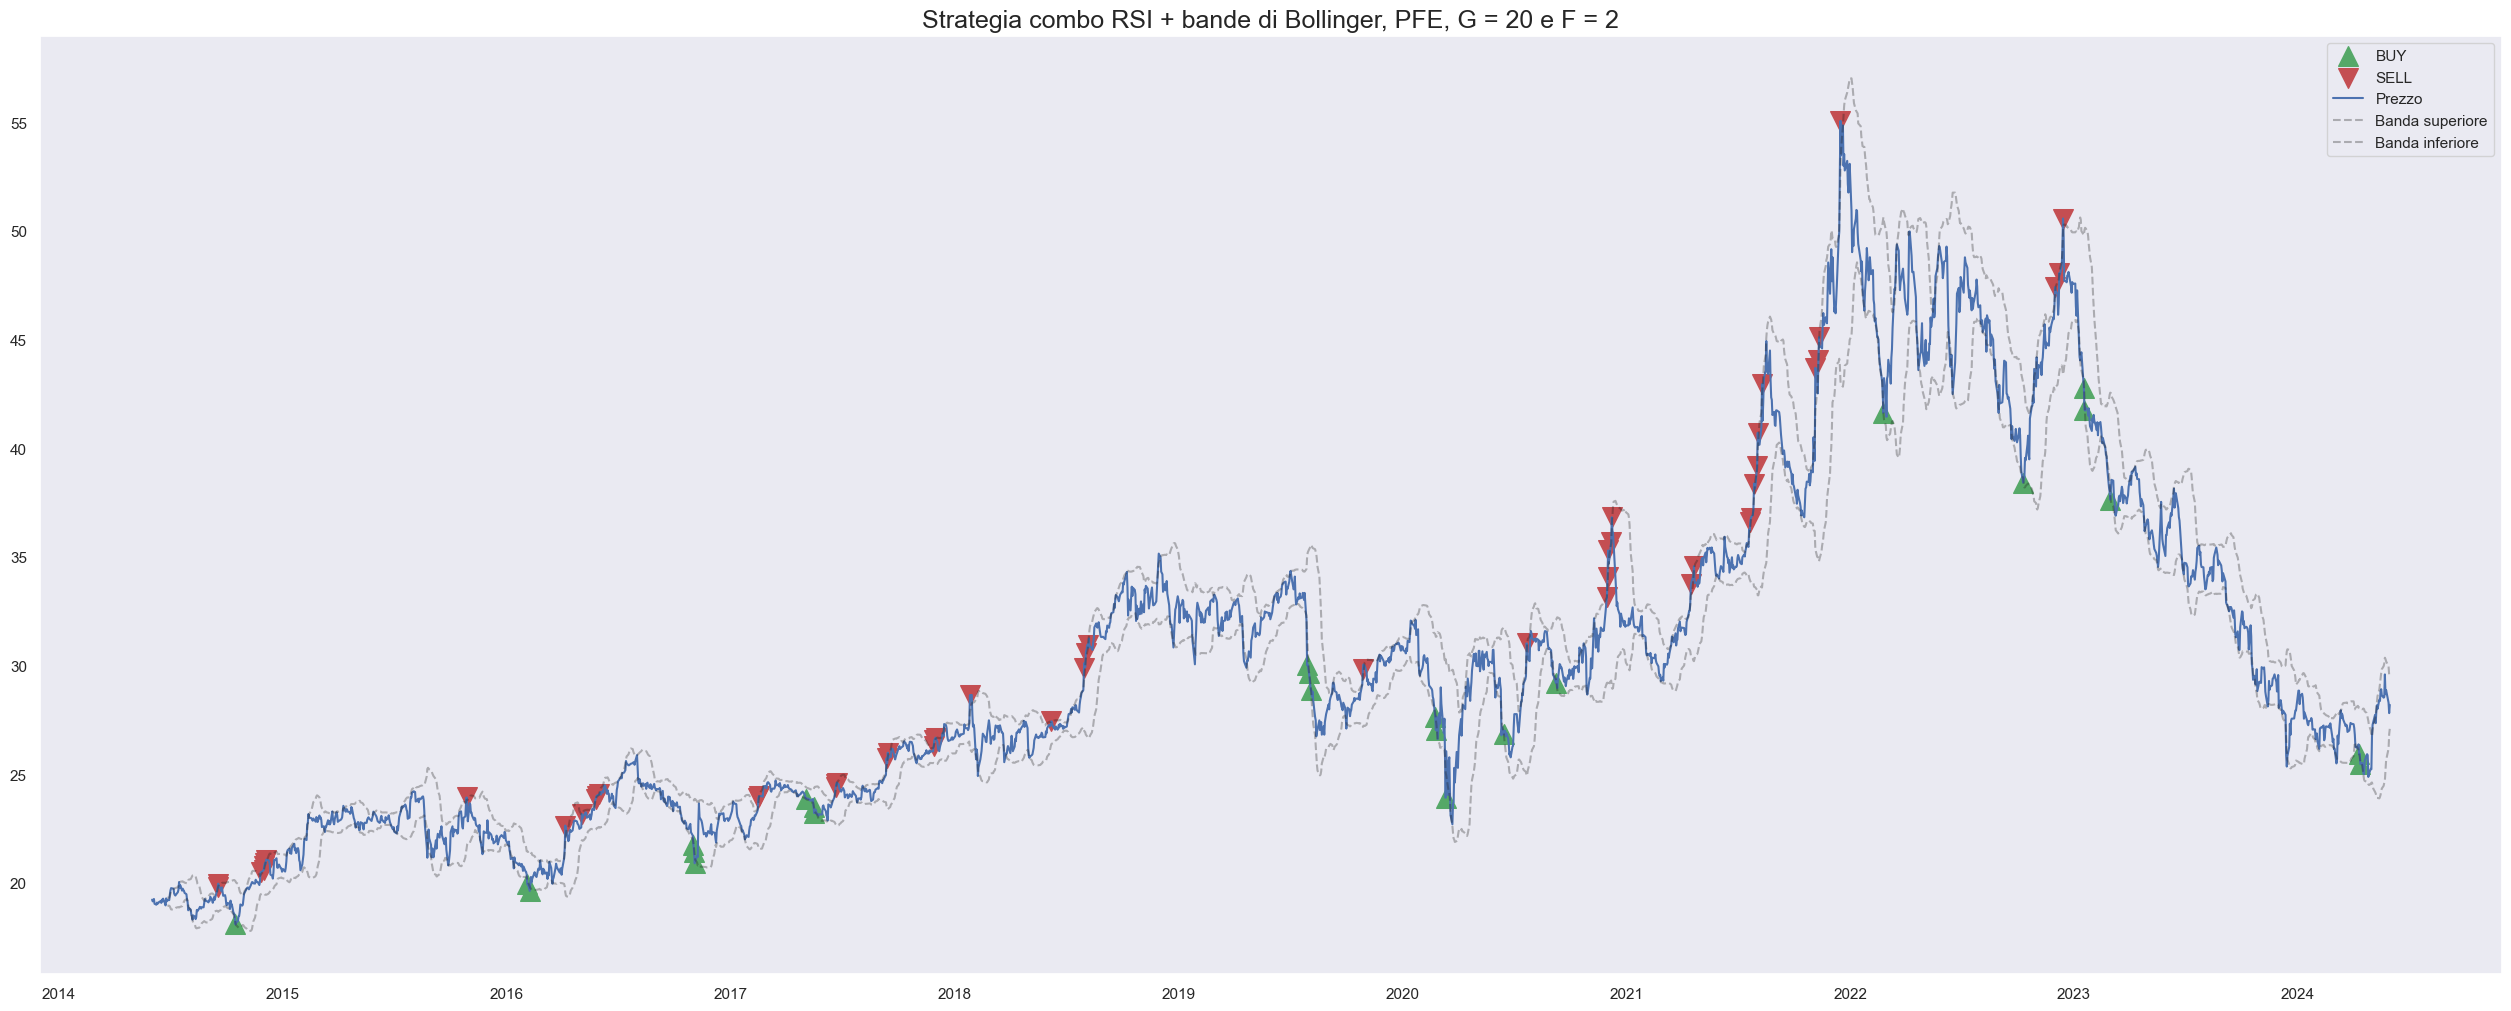

In [64]:
# plot segnali

data['buy_price'] = np.where((data['signal'] == 1), data['Adj Close'], np.nan)
data['sell_price'] = np.where((data['signal'] == -1), data['Adj Close'], np.nan)


plt.figure(figsize=(25,10), constrained_layout = True)
plt.title('Strategia combo RSI + bande di Bollinger, ' + name + ', G = ' + str(G) + ' e F = ' + str(F), fontsize=18)

plt.scatter(data.index, data['buy_price'], marker = '^', color = 'g', label = 'BUY', s = 200)
plt.scatter(data.index, data['sell_price'], marker = 'v', color = 'r', label = 'SELL', s = 200)


plt.plot(data['Adj Close'], label = 'Prezzo')
plt.plot(data['upper_band'], label = 'Banda superiore', color = 'k', linestyle = '--', alpha = 0.3)
plt.plot(data['lower_band'], label = 'Banda inferiore', color = 'k', linestyle = '--', alpha = 0.3)


plt.grid()
plt.legend();

Rendimenti della strategia e confronto con Buy & Hold

In [65]:
data['strategy_returns'] = simple_ret['[D] Simple ret. ' + name] * data['position']

data['buy_and_hold'] = (1 + simple_ret['[D] Simple ret. ' + name]).cumprod()

data['strategy'] = (1 + data['strategy_returns']).cumprod()

cum_rets = data[['buy_and_hold', 'strategy']]

cum_rets.tail()

buy_and_hold  strategy
Date                              
2024-05-23      1.491575  1.063863
2024-05-24      1.501453  1.070908
2024-05-28      1.471299  1.049401
2024-05-29      1.446344  1.031602
2024-05-30      1.466100  1.045693

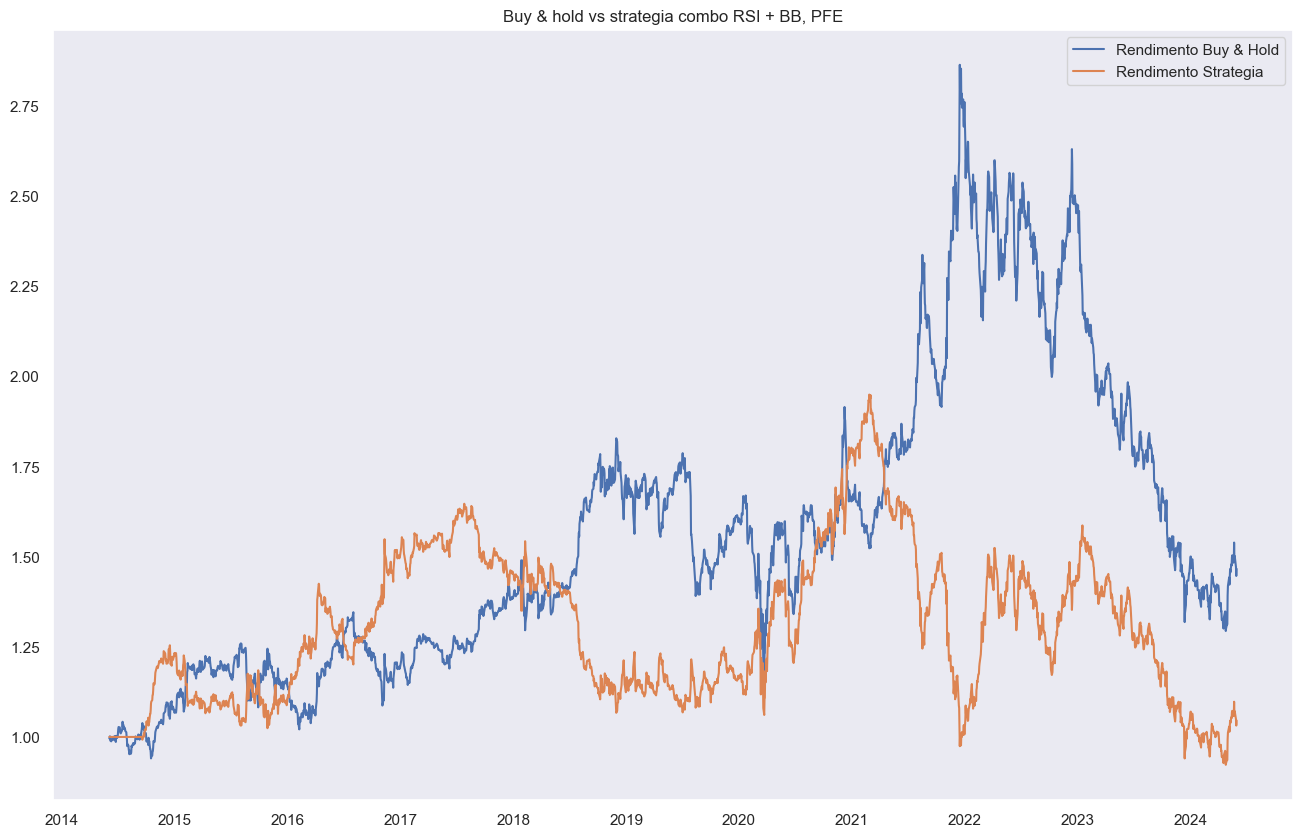

In [66]:
plt.figure(figsize=(16,10))
plt.title('Buy & hold vs strategia combo RSI + BB, ' + name)
plt.plot(cum_rets)
plt.legend(['Rendimento Buy & Hold', 'Rendimento Strategia'])
plt.grid()

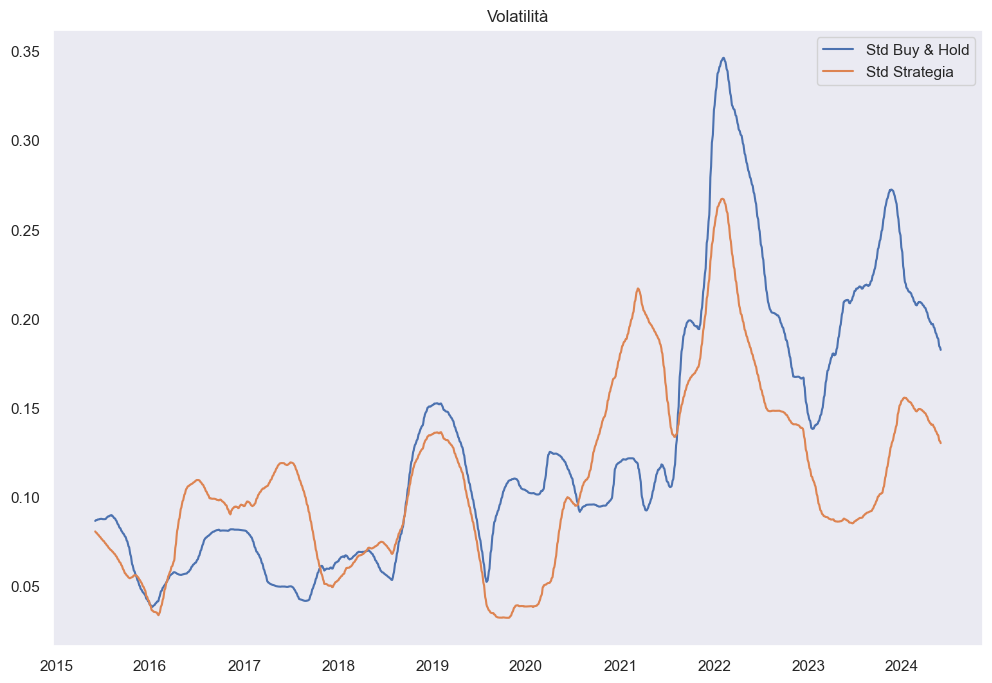

In [67]:
plt.figure(figsize=(12,8))
plt.title('Volatilità')
plt.plot(cum_rets.rolling(252).std())
plt.legend(['Std Buy & Hold', 'Std Strategia'])
plt.grid()

## 5. CAPM

In [68]:
# scarico S&P 500 da yfinance

sp_500 = yf.download('^GSPC', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [69]:
# calcolo i rendimenti semplici mensili di S&P500

m_rtn_market = sp_500['Adj Close'].resample('M').last().pct_change()
m_rtn_market.dropna(inplace=True)

m_rtn_market.head()

Date
2014-07-31   -0.015080
2014-08-31    0.037655
2014-09-30   -0.015514
2014-10-31    0.023201
2014-11-30    0.024534
Freq: ME, Name: Adj Close, dtype: float64

### Calcolo del beta di ciascun titolo

In [70]:
# li salvo in un dizionario per mostrarli dopo in maniera ordinata

betas = dict([])


# salvo anche i rendimenti semplici mensili per dopo

m_rtn = dict([])

for name in stocks_names:
    print("=== " + name + " ===")
    
    m_rtn_asset = m_adj(name).pct_change().dropna()
    
    m_rtn_asset.name = 'rtn_' + name
    
    df_asset_market = pd.DataFrame()
    df_asset_market[name] = m_rtn_asset
    df_asset_market['S&P500'] = m_rtn_market
    
    print("\nDataframe rendimenti semplici mensili:")
    print(df_asset_market.head(5))
    
    print("\nMatrice di covarianze:")
    cov_matrix = df_asset_market.cov()
    print(cov_matrix.head(5))
    
    cov = cov_matrix.loc[name, 'S&P500']
    print("\nCovarianza " + name + " e il mercato (S&P500): ", cov)
    
    var = df_asset_market['S&P500'].var()
    print("\nVarianza del mercato: ", var)
    
    # calcolo di beta
    beta = cov / var
    print("\nBeta: ", beta)
    
    # aggiorno i dict
    betas.update({name:beta})
    m_rtn.update({name:m_rtn_asset})
    
    print("\n\n")

=== JPM ===

Dataframe rendimenti semplici mensili:
                 JPM    S&P500
Date                          
2014-07-31  0.007865 -0.015080
2014-08-31  0.030865  0.037655
2014-09-30  0.013288 -0.015514
2014-10-31  0.010748  0.023201
2014-11-30 -0.005291  0.024534

Matrice di covarianze:
             JPM    S&P500
JPM     0.004882  0.002225
S&P500  0.002225  0.001955

Covarianza JPM e il mercato (S&P500):  0.00222451840864566

Varianza del mercato:  0.001954633753089726

Beta:  1.1380742838034605



=== GS ===

Dataframe rendimenti semplici mensili:
                  GS    S&P500
Date                          
2014-07-31  0.032430 -0.015080
2014-08-31  0.039310  0.037655
2014-09-30  0.024902 -0.015514
2014-10-31  0.034973  0.023201
2014-11-30 -0.005150  0.024534

Matrice di covarianze:
              GS    S&P500
GS      0.006597  0.002659
S&P500  0.002659  0.001955

Covarianza GS e il mercato (S&P500):  0.0026594591013953373

Varianza del mercato:  0.001954633753089726

Beta:  1.36

In [71]:
print("Beta di ciascun titolo rispetto al mercato (S&P500):")

pp.pprint(betas)

Beta di ciascun titolo rispetto al mercato (S&P500):
{'JPM': 1.1380742838034605,
 'GS': 1.3605920276325327,
 'PFE': 0.6700027543962702,
 'ABBV': 0.7449163009318894,
 'NVDA': 1.8057875783963406,
 'AAPL': 1.237934626736536}


### Esposizione di ciascun titolo rispetto ai fattori di rischio Fama-French

In [72]:
# dati scaricati da https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

# carico il csv togliendo le prime 3 righe
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

# tolgo la parte annual factors
indices = factor_df.iloc[:,0] == ' Annual Factors: January-December '
factor_df = factor_df[factor_df.index < factor_df[indices].index[0]]

# sistemo le colonne
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# da Ym a Y-m per la data
factor_df['date'] = pd.to_datetime(factor_df['date'], format='%Y%m').dt.strftime("%Y-%m")

# diventa l'index del dataframe
factor_df = factor_df.set_index('date')

# intervallo richiesto
factor_df = factor_df['2014-05-31':'2024-05-31']

# divisione per 100
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

factor_df.head()

mkt     smb     hml   rf
date                                
2014-06  0.0261  0.0309 -0.0070  0.0
2014-07 -0.0204 -0.0429  0.0003  0.0
2014-08  0.0424  0.0040 -0.0045  0.0
2014-09 -0.0197 -0.0371 -0.0134  0.0
2014-10  0.0252  0.0421 -0.0181  0.0

In [73]:
factor_df.tail()

mkt     smb     hml      rf
date                                   
2024-01  0.0070 -0.0509 -0.0238  0.0047
2024-02  0.0506 -0.0024 -0.0349  0.0042
2024-03  0.0283 -0.0249  0.0420  0.0043
2024-04 -0.0467 -0.0239 -0.0052  0.0047
2024-05  0.0434  0.0054 -0.0133  0.0044

In [74]:
# MODELLO A TRE FATTORI per ogni titolo
# i parametri mkt, smb e hml sono mostrati nel summary del modello OLS

for name in stocks_names:
    
    print("=====  " + name + "  =====")
    
    # ritorni semplici mensili dell'asset
    m_rtn_asset = m_rtn.get(name).copy()
    m_rtn_asset.index = m_rtn_asset.index.strftime('%Y-%m')
    m_rtn_asset.name = 'rtn_' + name
    
    # concatenazione e calcolo rendimenti in eccesso rispetto al risk free
    ff_df = pd.concat([factor_df, m_rtn_asset.to_frame()], axis=1)
    ff_df['excess_rtn_' + name] = ff_df['rtn_' + name] - ff_df['rf']
    
    print("\nDataframe dato dall'unione tra i dati F-F e " + name + ":\n")
    print(ff_df.head(5))
    
    print("\nMODELLO A TRE FATTORI " + name + ": ")
    # ols = ordinary least squares
    ff_model = smf.ols(formula = 'excess_rtn_' + name + ' ~ mkt + smb + hml', data = ff_df).fit()
    summary = ff_model.summary()
    print(summary)
    
    print("\n\n\n")

=====  JPM  =====

Dataframe dato dall'unione tra i dati F-F e JPM:

            mkt     smb     hml   rf   rtn_JPM  excess_rtn_JPM
2014-06  0.0261  0.0309 -0.0070  0.0       NaN             NaN
2014-07 -0.0204 -0.0429  0.0003  0.0  0.007865        0.007865
2014-08  0.0424  0.0040 -0.0045  0.0  0.030865        0.030865
2014-09 -0.0197 -0.0371 -0.0134  0.0  0.013288        0.013288
2014-10  0.0252  0.0421 -0.0181  0.0  0.010748        0.010748

MODELLO A TRE FATTORI JPM: 
                            OLS Regression Results                            
Dep. Variable:         excess_rtn_JPM   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     114.2
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           2.45e-34
Time:                        17:04:41   Log-Likelihood:                 230.60
No. Observations:                 119   AIC:      

### Utilizzo del beta per calcolare il rendimento atteso annuo

In [75]:
factor_df.tail()

mkt     smb     hml      rf
date                                   
2024-01  0.0070 -0.0509 -0.0238  0.0047
2024-02  0.0506 -0.0024 -0.0349  0.0042
2024-03  0.0283 -0.0249  0.0420  0.0043
2024-04 -0.0467 -0.0239 -0.0052  0.0047
2024-05  0.0434  0.0054 -0.0133  0.0044

In [76]:
# Ottengo il rendimento del T-bill a 1 anno
tbill_1y = yf.Ticker("^IRX")
tbill_1y_yield = tbill_1y.info['regularMarketPreviousClose'] / 100  # Converto in decimale

expected_mkt = factor_df.iloc[-12:, 0].mean() * 12 # 12 * (media ultimi 12 mesi colonna 0 = mkt)
expected_rf = factor_df.iloc[-12:, 3].mean() * 12 # 12 * (media ultimi 12 mesi colonna 3 = rf)
print("Tasso risk-free annuo: ", expected_rf)
print("Rendimento atteso annuo di mercato: ", expected_mkt, "\n")


m_expected_ret = dict([])
for name in stocks_names:
    tmp = expected_rf + betas.get(name) * (expected_mkt - expected_rf)
    print("Rendimento atteso annuo di " + name + ": " + str(tmp))
    m_expected_ret.update({name:tmp})

    
print("\n\n\nRendimento T-bill a 1 anno: ", tbill_1y_yield)

# Calcolo utilizzando il rendimento del T-bill a 1 anno
print("\nCalcolo utilizzando il rendimento del T-bill a 1 anno:")
m_expected_ret_tbill = dict([])
for name in stocks_names:
    tmp = tbill_1y_yield + betas.get(name) * (expected_mkt - tbill_1y_yield)
    print("Rendimento atteso annuo di " + name + " (usando T-bill): " + str(tmp))
    m_expected_ret_tbill.update({name:tmp})

Tasso risk-free annuo:  0.053000000000000005
Rendimento atteso annuo di mercato:  0.2082 

Rendimento atteso annuo di JPM: 0.2296291288462971
Rendimento atteso annuo di GS: 0.2641638826885691
Rendimento atteso annuo di PFE: 0.15698442748230113
Rendimento atteso annuo di ABBV: 0.16861100990462924
Rendimento atteso annuo di NVDA: 0.3332582321671121
Rendimento atteso annuo di AAPL: 0.24512745406951042



Rendimento T-bill a 1 anno:  0.051980000000000005

Calcolo utilizzando il rendimento del T-bill a 1 anno:
Rendimento atteso annuo di JPM (usando T-bill): 0.2297699646157766
Rendimento atteso annuo di GS (usando T-bill): 0.2645316865567543
Rendimento atteso annuo di PFE (usando T-bill): 0.15664783029178533
Rendimento atteso annuo di ABBV (usando T-bill): 0.16835082453157976
Rendimento atteso annuo di NVDA (usando T-bill): 0.3340801354970764
Rendimento atteso annuo di AAPL (usando T-bill): 0.24537014738878166


In [77]:
print(factor_df.columns)

Index(['mkt', 'smb', 'hml', 'rf'], dtype='object')


## 6. Costruzione di portafoglio

In [78]:
# rendimenti passati, primi 108 mesi

ret_df = pd.DataFrame()
for name in stocks_names:
    ret_df = pd.concat([ret_df, m_rtn.get(name)[:108].to_frame()], axis=1)
    
ret_df.tail()

rtn_JPM    rtn_GS   rtn_PFE  rtn_ABBV  rtn_NVDA  rtn_AAPL
Date                                                                  
2023-02-28  0.024221 -0.038708 -0.081295  0.041624  0.188309  0.023183
2023-03-31 -0.090966 -0.063125  0.005669  0.035543  0.196663  0.118649
2023-04-30  0.069181  0.049922 -0.046814 -0.043043 -0.001008  0.028987
2023-05-31 -0.018301 -0.049714 -0.011792 -0.087083  0.363437  0.046058
2023-06-30  0.071697 -0.004199 -0.035245 -0.023413  0.118210  0.094330

In [79]:
def print_portfolio(portfolio, msg):
    print("=== " + msg + " ===")
    print("Rendimento atteso: ", portfolio['returns'])
    print("Volatilità: ", portfolio['volatility'])
    print("Sharpe Ratio: ", portfolio['sharpe_ratio'], "\n")

In [80]:
# inizializzazione
n_portfolio = 10 ** 5
n_period = 12

n_assets = len(stocks_names) # 6

# matrice di covarianze
cov_mat = ret_df.cov() * n_period

### Metodo di simulazione (Monte Carlo), rendimenti passati

In [81]:
# rendimenti
avg_ret = ret_df.mean() * n_period

In [82]:
# pesi casuali
np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

# rendimenti di portfolio
portfolio_rtn = np.dot(weights, avg_ret)

portfolio_vol = []
for i in range(0, len(weights)):
    portfolio_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portfolio_vol = np.array(portfolio_vol)  

# nuovo df
portfolio_results_df = pd.DataFrame({'returns': portfolio_rtn,
                                 'volatility': portfolio_vol,
                                 'sharpe_ratio': portfolio_rtn / portfolio_vol}) # rf = 0

past_rtn_min = portfolio_results_df.returns.min() # così lo riutilizzo più avanti
past_rtn_max = portfolio_results_df.returns.max()

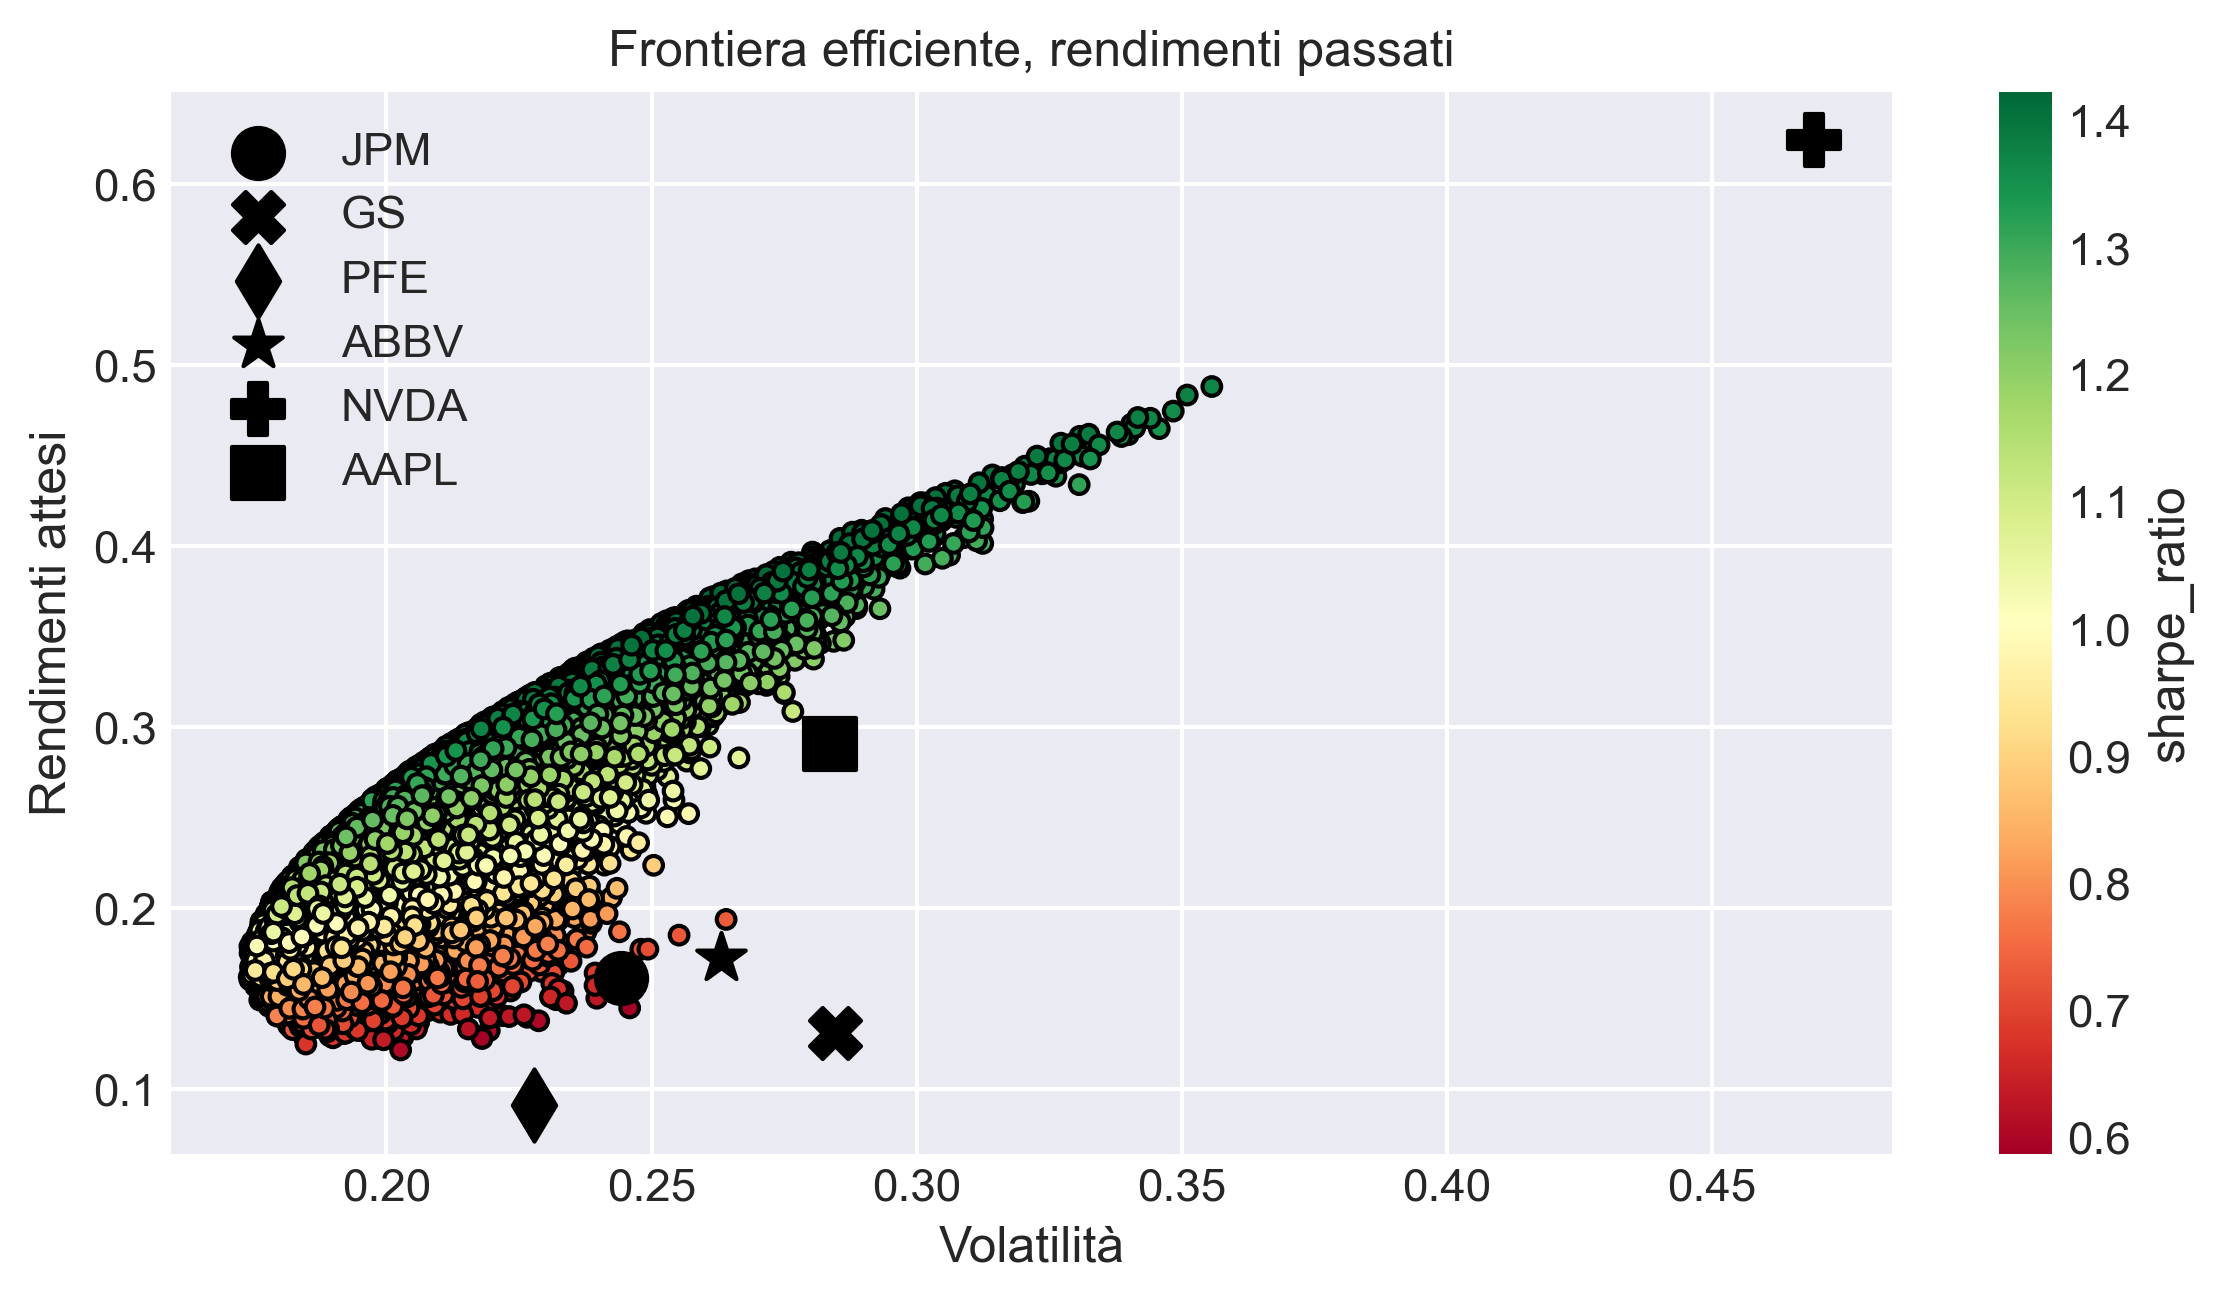

In [83]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

MARKS = ['o', 'X', 'd', '*', 'P', 's']

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatilità', 
       ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, rendimenti passati')

#ax.plot(portfolio_vol_ef, portfolio_rtn_ef, 'b--')

for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), # varianza
                y=avg_ret[asset_index], # media
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [84]:
# max sharpe ratio

max_sr = np.argmax(portfolio_results_df.sharpe_ratio)
max_sr_portfolio = portfolio_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portfolio_results_df.sharpe_ratio)]

print_portfolio(max_sr_portfolio, "Portfolio con sharpe ratio massimo")
print("=== Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio rispetto al mercato 
# (= somma pesata dei beta degli asset rispetto al mercato = dot product)

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(portfolio_results_df.volatility)
min_vol_portfolio = portfolio_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portfolio_results_df.volatility)]

print_portfolio(min_vol_portfolio, "Portfolio con volatilità minima")
print("=== Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(portfolio_results_df.returns)
max_ret_portfolio = portfolio_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portfolio_results_df.returns)]

print_portfolio(max_ret_portfolio, "Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== Portfolio con sharpe ratio massimo ===
Rendimento atteso:  0.371457422509144
Volatilità:  0.260947254155324
Sharpe Ratio:  1.4234961916404796 

=== Pesi portfolio con max sr ===
JPM:  0.1176241967138763
GS:  0.010731929577747953
PFE:  0.006292107359257146
ABBV:  0.2743355079149913
NVDA:  0.3933732804224931
AAPL:  0.19764297801163427

=== Beta portfolio con max sr rispetto al mercato ===
Beta:  1.3120572419615537


---------------------------------------------------------------------------


=== Portfolio con volatilità minima ===
Rendimento atteso:  0.16218627274027217
Volatilità:  0.17411673545053596
Sharpe Ratio:  0.931480091908494 

=== Pesi portfolio con min volatility ===
JPM:  0.23782532253818742
GS:  0.029004411973438227
PFE:  0.35813987272225073
ABBV:  0.19304508929639547
NVDA:  0.0035700724484752882
AAPL:  0.1784152310212528

=== Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.9211963752298182


-----------------------------------------------------------

In [85]:
# portfolio effettivo

weights = np.array([1/6] * n_assets)

eff_portfolio=dict([])

eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})

print_portfolio(eff_portfolio, "Portfolio effettivo rendimenti passati")

beta_eff = np.dot(weights, list(betas.values()))
print("Beta: ", beta_eff)

=== Portfolio effettivo rendimenti passati ===
Rendimento atteso:  0.24521315803039465
Volatilità:  0.20067157956828452
Sharpe Ratio:  1.2219625646936891 

Beta:  1.1595512619828383


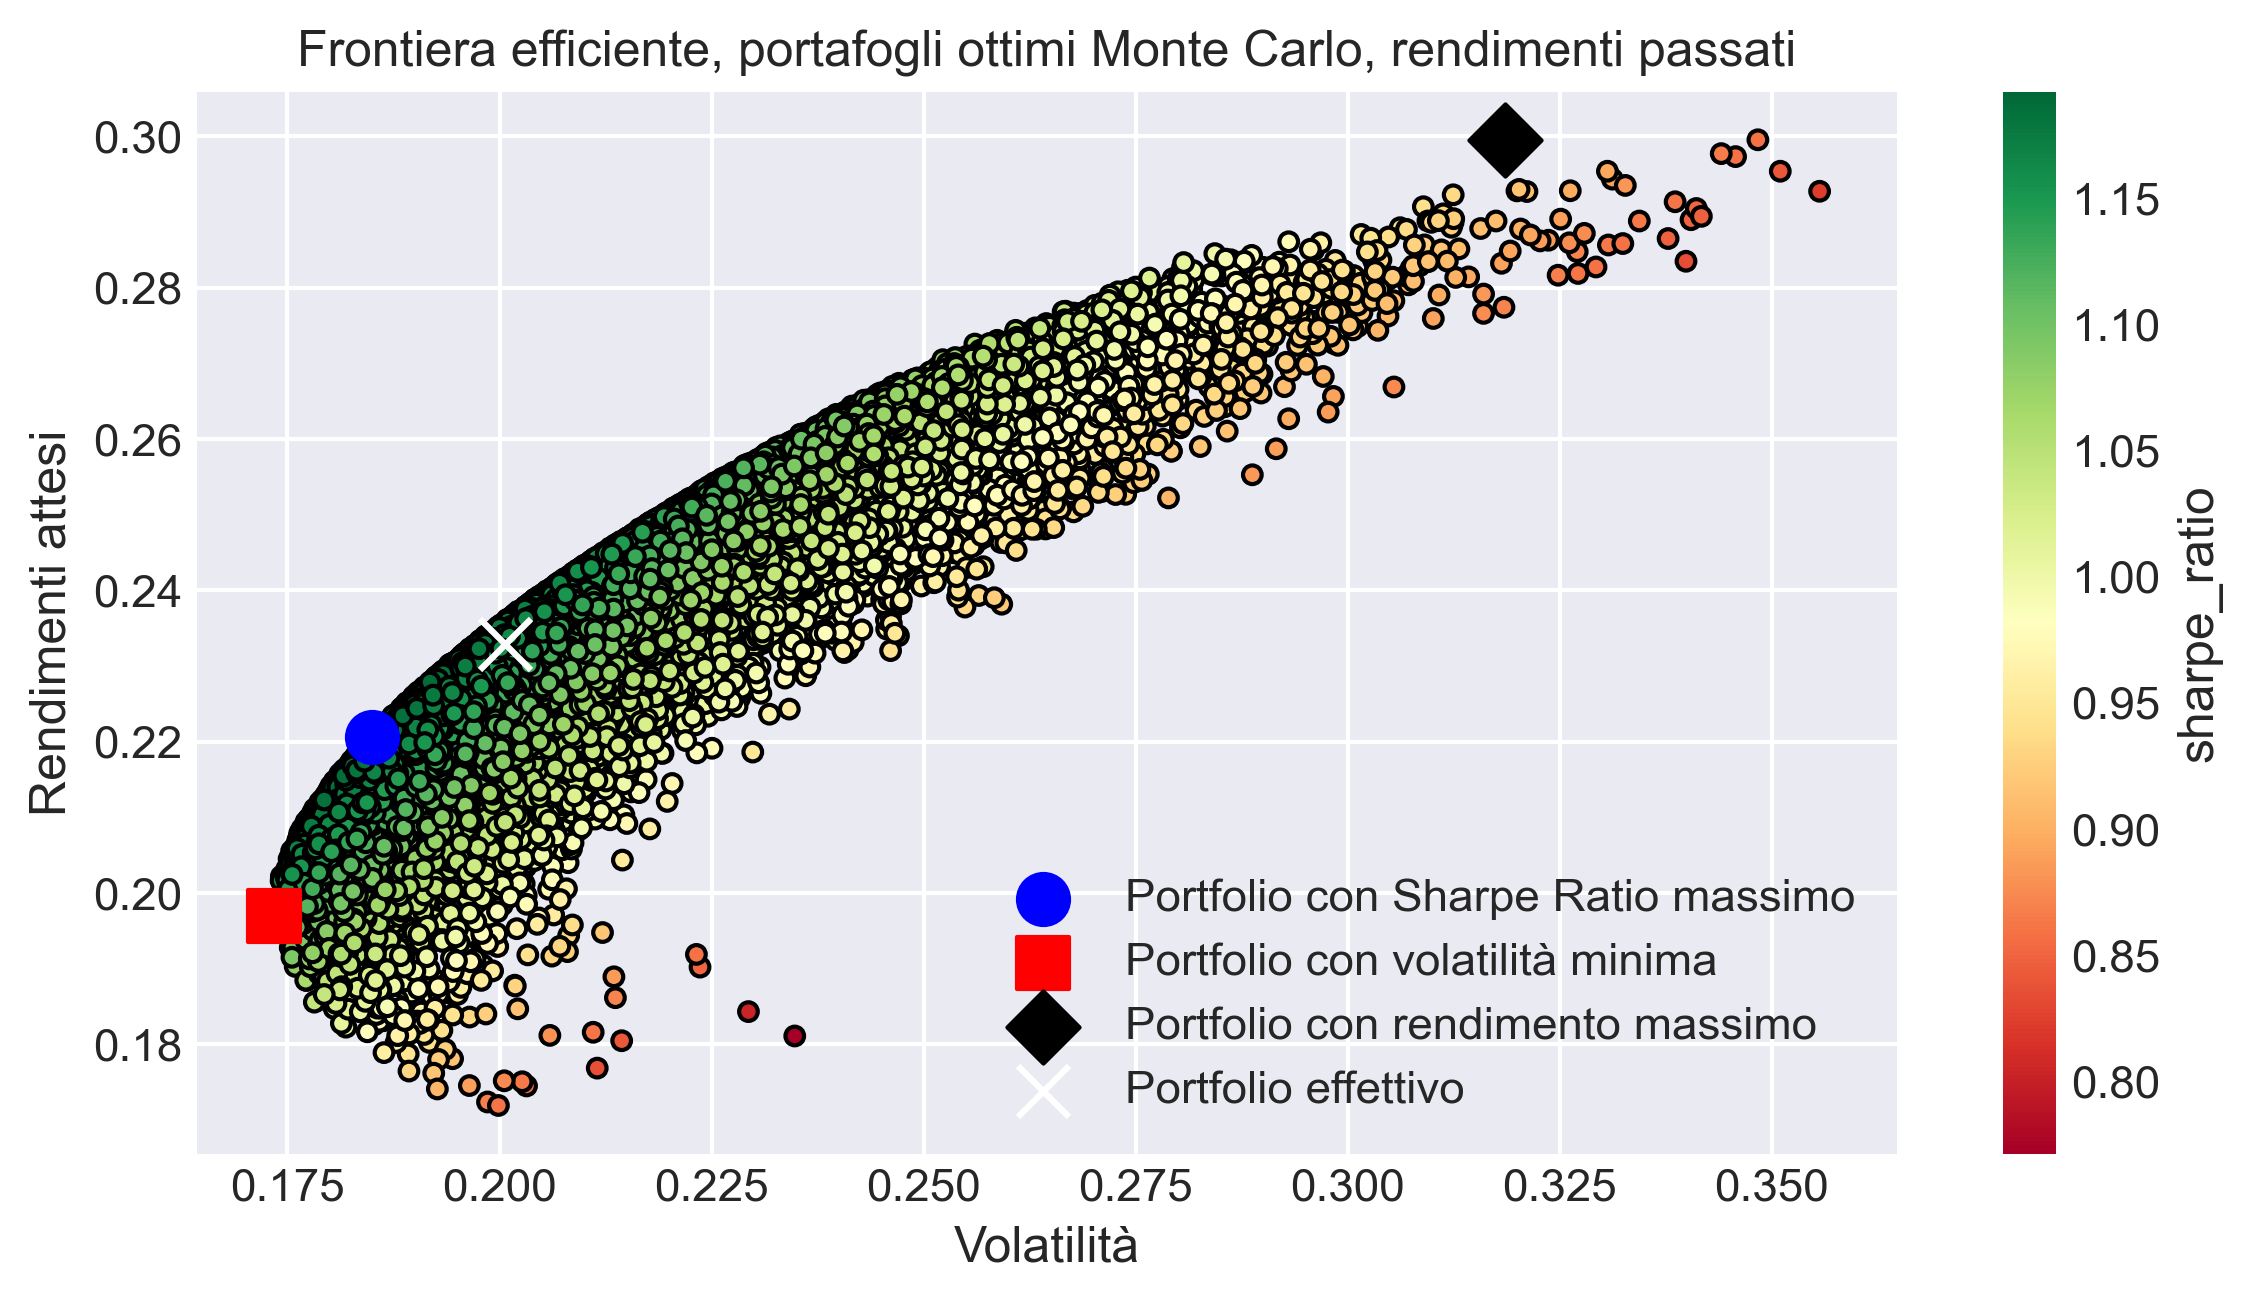

In [103]:
# mostro gli ottimi in un grafico

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, 
           y=max_sr_portfolio.returns, 
           c='blue', marker='o', 
           s=150, label='Portfolio con Sharpe Ratio massimo')

ax.scatter(x=min_vol_portfolio.volatility, 
           y=min_vol_portfolio.returns, 
           c='red', marker='s', 
           s=150, label='Portfolio con volatilità minima')

ax.scatter(x=max_ret_portfolio.volatility, 
           y=max_ret_portfolio.returns, 
           c='black', marker='D', 
           s=150, label='Portfolio con rendimento massimo')

ax.scatter(x=eff_portfolio['volatility'], 
           y=eff_portfolio['returns'], 
           c='white', marker='x', 
           s=150, label='Portfolio effettivo')


ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, portafogli ottimi Monte Carlo, rendimenti passati')
ax.legend()

plt.tight_layout()

plt.show()

### Metodo di simulazione (Monte Carlo), rendimenti attesi costruiti nel punto 5

In [87]:
# rendimenti
avg_ret = np.array(list(m_expected_ret.values()))

In [88]:
# da qui tutto uguale a prima

np.random.seed(42)
weights = np.random.random(size=(n_portfolio, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

portfolio_rtn = np.dot(weights, avg_ret)

portfolio_vol = []
for i in range(0, len(weights)):
    portfolio_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portfolio_vol = np.array(portfolio_vol)  

portfolio_results_df = pd.DataFrame({'returns': portfolio_rtn,
                                 'volatility': portfolio_vol,
                                 'sharpe_ratio': portfolio_rtn / portfolio_vol})

expected_rtn_min = portfolio_results_df.returns.min() # lo riutilizzerò
expected_rtn_max = portfolio_results_df.returns.max()

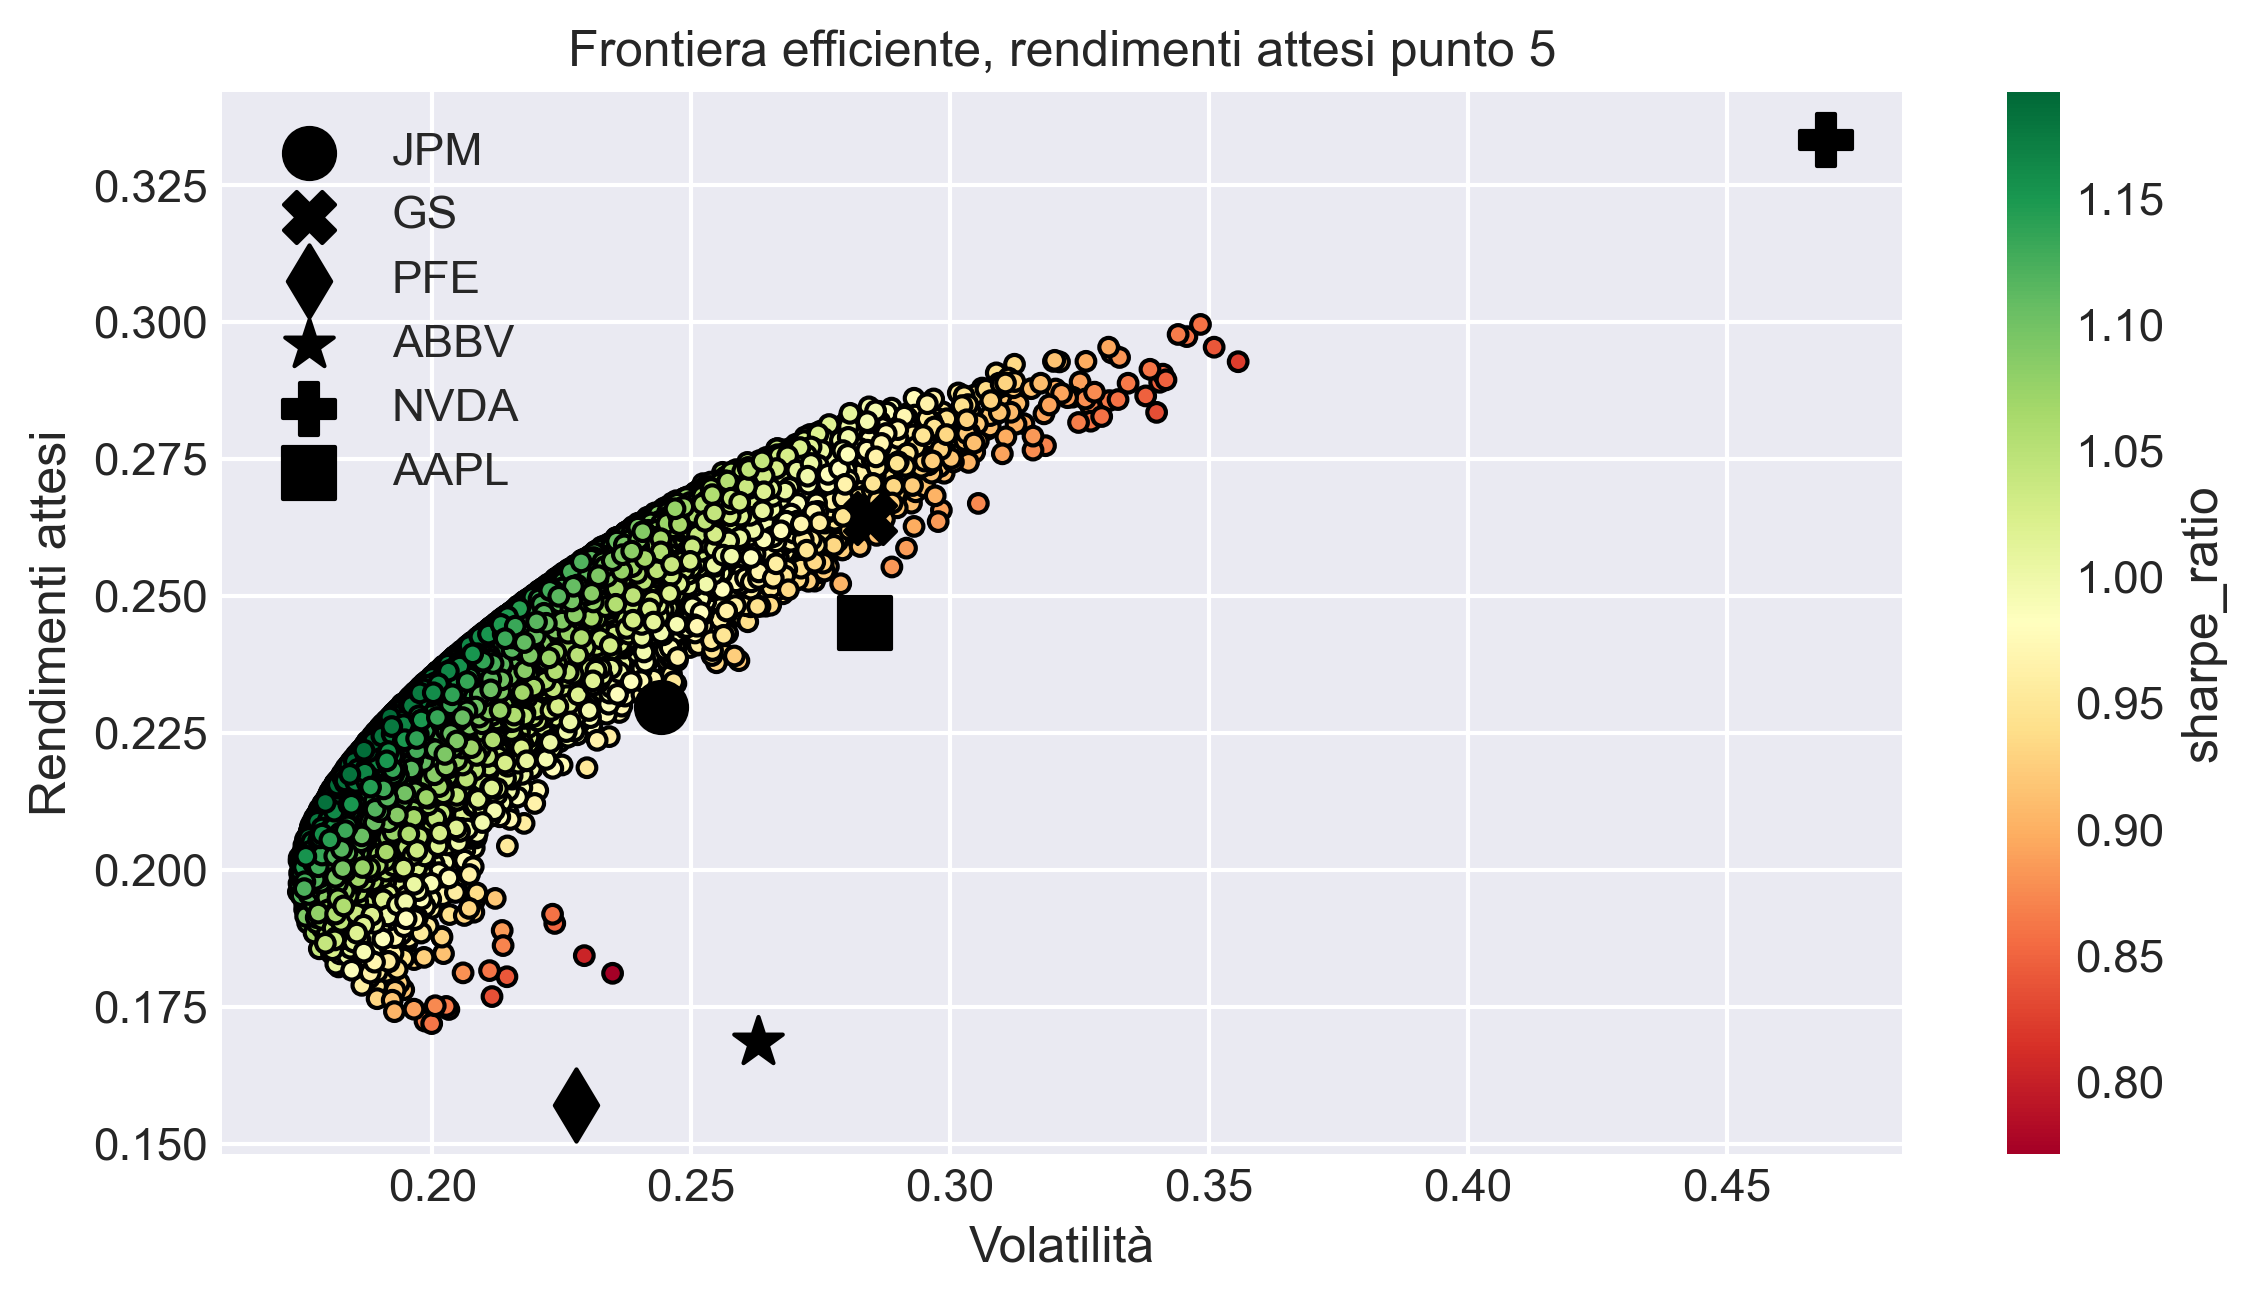

In [89]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

MARKS = ['o', 'X', 'd', '*', 'P', 's']

fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatilità', 
       ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, rendimenti attesi punto 5')

for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_ret[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [90]:
# max sharpe ratio

max_sr = np.argmax(portfolio_results_df.sharpe_ratio)
max_sr_portfolio = portfolio_results_df.loc[max_sr]
max_sr_weights = weights[np.argmax(portfolio_results_df.sharpe_ratio)]

print_portfolio(max_sr_portfolio, "Portfolio con sharpe ratio massimo")
print("=== Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(portfolio_results_df.volatility)
min_vol_portfolio = portfolio_results_df.loc[min_vol]
min_vol_weights = weights[np.argmin(portfolio_results_df.volatility)]

print_portfolio(min_vol_portfolio, "Portfolio con volatilità minima")
print("=== Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(portfolio_results_df.returns)
max_ret_portfolio = portfolio_results_df.loc[max_ret]
max_ret_weights = weights[np.argmax(portfolio_results_df.returns)]

print_portfolio(max_ret_portfolio, "Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== Portfolio con sharpe ratio massimo ===
Rendimento atteso:  0.21862086868463315
Volatilità:  0.18334853970486129
Sharpe Ratio:  1.1923785650900205 

=== Pesi portfolio con max sr ===
JPM:  0.29930955462407793
GS:  0.06489280197605839
PFE:  0.18525113569100995
ABBV:  0.14348266728690798
NVDA:  0.047704826982784394
AAPL:  0.25935901343916123

=== Beta portfolio con max sr rispetto al mercato ===
Beta:  1.0671447724525334


---------------------------------------------------------------------------


=== Portfolio con volatilità minima ===
Rendimento atteso:  0.19596967743566782
Volatilità:  0.17411673545053596
Sharpe Ratio:  1.1255074185062466 

=== Pesi portfolio con min volatility ===
JPM:  0.23782532253818742
GS:  0.029004411973438227
PFE:  0.35813987272225073
ABBV:  0.19304508929639547
NVDA:  0.0035700724484752882
AAPL:  0.1784152310212528

=== Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.9211963752298182


----------------------------------------------------

In [91]:
# portfolio effettivo

weights = np.array([1/6] * n_assets)

eff_portfolio=dict([])

eff_portfolio.update({'returns': np.dot(weights, avg_ret)})
eff_portfolio.update({'volatility': np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))})
eff_portfolio.update({'sharpe_ratio': eff_portfolio['returns'] / eff_portfolio['volatility']})

print_portfolio(eff_portfolio, "Portfolio effettivo")

beta_eff = np.dot(weights, list(betas.values()))
print("Beta: ", beta_eff)

=== Portfolio effettivo ===
Rendimento atteso:  0.23296235585973651
Volatilità:  0.20067157956828452
Sharpe Ratio:  1.1609135501944066 

Beta:  1.1595512619828383


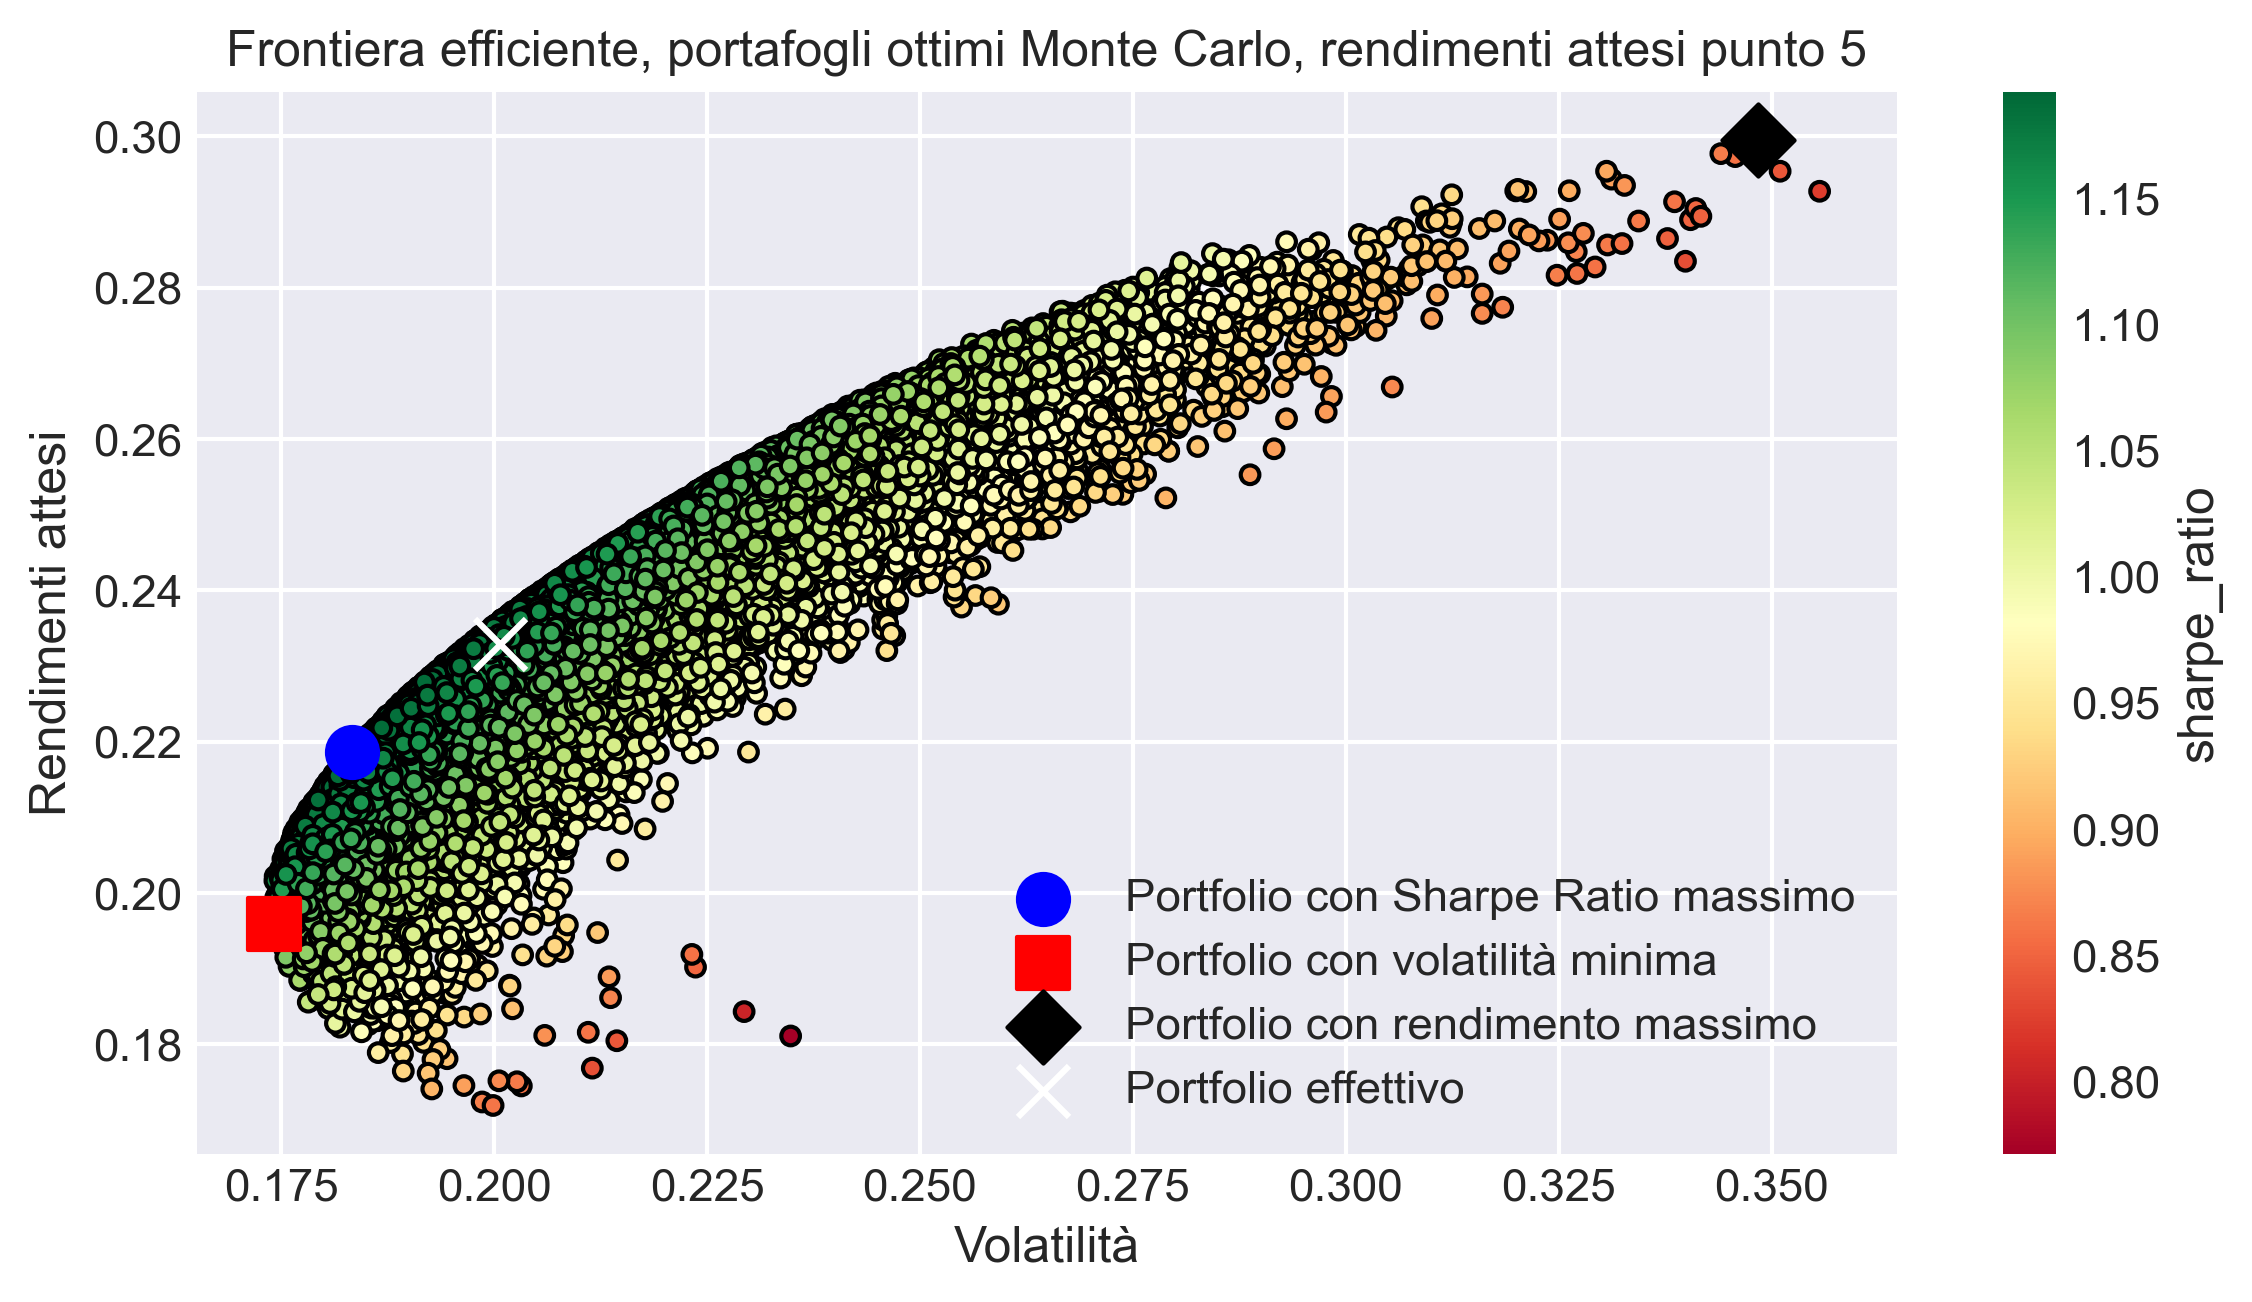

In [92]:
fig, ax = plt.subplots()
portfolio_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)

ax.scatter(x=max_sr_portfolio.volatility, 
           y=max_sr_portfolio.returns, 
           c='blue', marker='o', 
           s=150, label='Portfolio con Sharpe Ratio massimo')

ax.scatter(x=min_vol_portfolio.volatility, 
           y=min_vol_portfolio.returns, 
           c='red', marker='s', 
           s=150, label='Portfolio con volatilità minima')

ax.scatter(x=max_ret_portfolio.volatility, 
           y=max_ret_portfolio.returns, 
           c='black', marker='D', 
           s=150, label='Portfolio con rendimento massimo')

ax.scatter(x=eff_portfolio['volatility'], 
           y=eff_portfolio['returns'], 
           c='white', marker='x', 
           s=150, label='Portfolio effettivo')


ax.set(xlabel='Volatilità', ylabel='Rendimenti attesi', 
       title='Frontiera efficiente, portafogli ottimi Monte Carlo, rendimenti attesi punto 5')
ax.legend()

plt.tight_layout()

plt.show()

### Metodo analitico (SciPy), rendimenti passati

In [93]:
# rendimenti
avg_ret = ret_df.mean() * n_period
# cov_mat già definita
rtns_range = np.linspace(past_rtn_min, # riutilizzo le variabili definite prima
                         past_rtn_max,
                         200)

In [94]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier():
    
    efficient_portfolios = []
    
    n_assets = len(avg_ret)
    args = (avg_ret, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_ret) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [95]:
efficient_portfolios = get_efficient_frontier()

vols_range = [x['fun'] for x in efficient_portfolios]

In [96]:
# preparazione dataframe

all_portfolio_df = pd.DataFrame()

all_portfolio_df.index = [i for i in range(0,len(vols_range))]

all_portfolio_df['returns'] = np.nan
all_portfolio_df['volatility'] = np.nan
all_portfolio_df['sharpe_ratio'] = np.nan

for vol in range(0,len(vols_range)):
    all_portfolio_df.iloc[vol, 0] = rtns_range[vol] # returns
    all_portfolio_df.iloc[vol, 1] = efficient_portfolios[vol]['fun'] # volatility
    all_portfolio_df.iloc[vol, 2] = rtns_range[vol] / efficient_portfolios[vol]['fun'] # sharpe_ratio
    

all_portfolio_df.tail()

returns  volatility  sharpe_ratio
195  0.480875    0.342261      1.404993
196  0.482717    0.343779      1.404147
197  0.484559    0.345301      1.403292
198  0.486400    0.346827      1.402431
199  0.488242    0.348356      1.401562

In [97]:
# max sharpe ratio

max_sr = np.argmax(all_portfolio_df.sharpe_ratio)
max_sr_portfolio = all_portfolio_df.loc[max_sr]
max_sr_weights = efficient_portfolios[max_sr]['x']

print_portfolio(max_sr_portfolio, "(SciPy) Portfolio con sharpe ratio massimo")
print("=== (SciPy) Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(all_portfolio_df.volatility)
min_vol_portfolio = all_portfolio_df.loc[min_vol]
min_vol_weights = efficient_portfolios[min_vol]['x']

print_portfolio(min_vol_portfolio, "(SciPy) Portfolio con volatilità minima")
print("=== (SciPy) Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(all_portfolio_df.returns)
max_ret_portfolio = all_portfolio_df.loc[max_ret]
max_ret_weights = efficient_portfolios[max_ret]['x']

print_portfolio(max_ret_portfolio, "(SciPy) Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== (SciPy) Portfolio con sharpe ratio massimo ===
Rendimento atteso:  0.3887862915695487
Volatilità:  0.27196885843023744
Sharpe Ratio:  1.4295250339085275 

=== (SciPy) Pesi portfolio con max sr ===
JPM:  0.06916545222182945
GS:  4.732383307910673e-17
PFE:  0.0
ABBV:  0.2740660789860914
NVDA:  0.4174699332939107
AAPL:  0.2392985354981683

=== (SciPy) Beta portfolio con max sr rispetto al mercato ===
Beta:  1.3329696753871447


---------------------------------------------------------------------------


=== (SciPy) Portfolio con volatilità minima ===
Rendimento atteso:  0.16777332591093852
Volatilità:  0.17338484502108242
Sharpe Ratio:  0.967635469469886 

=== (SciPy) Pesi portfolio con min volatility ===
JPM:  0.2577820287667215
GS:  0.0
PFE:  0.34199105806357083
ABBV:  0.18033614750888693
NVDA:  1.9061507474365939e-19
AAPL:  0.21989076566082078

=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.9290557774853437


----------------------------------------

### Metodo analitico (SciPy), rendimenti attesi costruiti nel punto 5

In [98]:
# rendimenti
avg_ret = np.array(list(m_expected_ret.values()))
# cov_mat già definita
rtns_range = np.linspace(expected_rtn_min, # diverse dalle variabili per rendimenti passati
                         expected_rtn_max,
                         200)

In [99]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

def get_efficient_frontier():
    
    efficient_portfolios = []
    
    n_assets = len(avg_ret)
    args = (avg_ret, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_ret) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [100]:
efficient_portfolios = get_efficient_frontier()

vols_range = [x['fun'] for x in efficient_portfolios]

In [101]:
# preparazione dataframe

all_portfolio_df = pd.DataFrame()

all_portfolio_df.index = [i for i in range(0,len(vols_range))]

all_portfolio_df['returns'] = np.nan
all_portfolio_df['volatility'] = np.nan
all_portfolio_df['sharpe_ratio'] = np.nan

for vol in range(0,len(vols_range)):
    all_portfolio_df.iloc[vol, 0] = rtns_range[vol] # returns
    all_portfolio_df.iloc[vol, 1] = efficient_portfolios[vol]['fun'] # volatility
    all_portfolio_df.iloc[vol, 2] = rtns_range[vol] / efficient_portfolios[vol]['fun'] # sharpe_ratio
    

all_portfolio_df.tail()

returns  volatility  sharpe_ratio
195  0.296989    0.310471      0.956574
196  0.297630    0.312422      0.952655
197  0.298271    0.314416      0.948653
198  0.298913    0.316453      0.944573
199  0.299554    0.318531      0.940423

In [102]:
# max sharpe ratio

max_sr = np.argmax(all_portfolio_df.sharpe_ratio)
max_sr_portfolio = all_portfolio_df.loc[max_sr]
max_sr_weights = efficient_portfolios[max_sr]['x']

print_portfolio(max_sr_portfolio, "(SciPy) Portfolio con sharpe ratio massimo")
print("=== (SciPy) Pesi portfolio con max sr ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_sr_weights[index])

# beta portfolio

beta_max_sr = np.dot(max_sr_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max sr rispetto al mercato ===")
print("Beta: ", beta_max_sr)

    
print("\n\n---------------------------------------------------------------------------\n\n")

# min volatility

min_vol = np.argmin(all_portfolio_df.volatility)
min_vol_portfolio = all_portfolio_df.loc[min_vol]
min_vol_weights = efficient_portfolios[min_vol]['x']

print_portfolio(min_vol_portfolio, "(SciPy) Portfolio con volatilità minima")
print("=== (SciPy) Pesi portfolio con min volatility ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", min_vol_weights[index])

# beta portfolio

beta_min_vol = np.dot(min_vol_weights, list(betas.values()))

print("\n=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===")
print("Beta: ", beta_min_vol)
    

print("\n\n---------------------------------------------------------------------------\n\n")
    
# max returns

max_ret = np.argmax(all_portfolio_df.returns)
max_ret_portfolio = all_portfolio_df.loc[max_ret]
max_ret_weights = efficient_portfolios[max_ret]['x']

print_portfolio(max_ret_portfolio, "(SciPy) Portfolio con rendimento massimo")
print("=== Pesi portfolio con max returns ===")
for index in range(0, len(stocks_names)):
    print(stocks_names[index] + ": ", max_ret_weights[index])
    
# beta portfolio

beta_max_ret = np.dot(max_ret_weights, list(betas.values()))
    
print("\n=== (SciPy) Beta portfolio con max returns rispetto al mercato ===")
print("Beta: ", beta_max_ret)

=== (SciPy) Portfolio con sharpe ratio massimo ===
Rendimento atteso:  0.22066922512296586
Volatilità:  0.1849303474664201
Sharpe Ratio:  1.193255883342972 

=== (SciPy) Pesi portfolio con max sr ===
JPM:  0.28794347617389926
GS:  0.085900678830409
PFE:  0.19671842079324
ABBV:  0.11689258872931396
NVDA:  0.052793506245280994
AAPL:  0.25975132922785676

=== (SciPy) Beta portfolio con max sr rispetto al mercato ===
Beta:  1.0803429453716389


---------------------------------------------------------------------------


=== (SciPy) Portfolio con volatilità minima ===
Rendimento atteso:  0.19693961177895816
Volatilità:  0.1733853004713999
Sharpe Ratio:  1.1358495284405241 

=== (SciPy) Pesi portfolio con min volatility ===
JPM:  0.2550587198992969
GS:  0.0
PFE:  0.34398465385317956
ABBV:  0.1818564748589085
NVDA:  0.0
AAPL:  0.2191001513886151

=== (SciPy) Beta portfolio con min volatility rispetto al mercato ===
Beta:  0.9274459522084927


-------------------------------------------------